# Diagnosis of learning curves of individual parameter

Alana Jaskir <br>
Brown University, Providence, RI, USA <br>
Laboratory for Neural Computation and Cognition <br>
Michael Frank <br>

Average learning curves and trial-by-trial visualization of choice and reward and their impact
on G and N weights for a specified parameter combination

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import importlib
from sklearn import metrics
import pickle

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
# my models
import opal
from opal import OpAL
import learning
import plot_dynamics
from scipy.stats import beta as beta_rv

# data directory
path2 = "../standard_rl/"
sys.path.insert(1, os.path.join(sys.path[0], path2))
import rl
from rl import RL
import learn

# auc plotter
sys.path.insert(1, os.path.join(sys.path[0], '../../helpers/'))
import aucplotter

%matplotlib inline


In [2]:
# other paths
path_seeds = "../random_seeds/"
path_params = "../../model_cmp/filter_1.00/revisions2/all/"

# generate new random seeds?
new_seeds = False

In [3]:
k = 20
n_states = 1000
rho = 0.0
crit = "SA"

# reward mag and loss mag
# same for each
r_mag = 1
l_mag = 0
v0 = 0.5*r_mag + .5*l_mag

# magnitude
norm = True
mag = r_mag - l_mag

# anneal learning rate?
anneal = True
use_var = True
T = 10.0

# decay to prior?
decay_to_prior = False
decay_to_prior_gamma = 5

# pgrad?
pgrad = False

# only modify sufficiently above 50%
phi = 1.0

# ax labels
ax_labels_best = {"80": "80%", "30": "30%"}
ax_labels_worst = {"80": "70%", "30": "20%"}

In [4]:
ntrials = 250
complexity = 2
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/auc_order.pkle" %(ntrials)
auc_orders = pickle.load(open(full_param_path,"rb")) # parameters order by AUCS across environment, keys: 'UCB', 'SACrit_BayesAnneal', 'SACrit_BayesAnneal_mod', 'RL', 'NoHebb', 'Bmod'

# Lean

In [5]:
# reproduce optimal learning curve
env = "30_10_%d" %(complexity)

if not new_seeds:
        # use random seeds used to produce histograms and figs in paper
        rnd_seeds_OpAL = pickle.load(open("../random_seeds/OpAL/%s_rnd_seeds.pkle" %(env),"rb"))
        rnd_seeds_RL = pickle.load(open("../random_seeds/RL/%s_rnd_seeds.pkle" %(env),"rb"))
        rnd_seeds_UCB = pickle.load(open("../random_seeds/UCB/%s_rnd_seeds.pkle" %(env),"rb"))
else:
        new_seeds_please = np.random.randint(1,100000,n_states)
        rnd_seeds_OpAL = rnd_seeds_RL = rnd_seeds_UCB = new_seeds_please

# L_states_OpAL_plus = learning.simulate(auc_orders[str_complexity]['SACrit_BayesAnneal'][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="constant",k=k,norm=norm,    
#         mag=mag,rnd_seeds=rnd_seeds_OpAL,anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
#         decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
L_states_OpAL_Star = learning.simulate(auc_orders[str_complexity]['SACrit_BayesAnneal_mod'][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
L_states_OpAL_NoHebb = learning.simulate(auc_orders[str_complexity]['NoHebb'][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad, 
        hebb=False)
L_UCB = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=auc_orders[str_complexity]['UCB'][0],rnd_seeds=rnd_seeds_UCB)
L_Q = learn.simulate(auc_orders[str_complexity]['RL'][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)

In [6]:
# run Q with full information
env = "30_10_1" 
L_Q_Full_best = learn.simulate(auc_orders[str_complexity]['RL'][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)
L_UCB_Full_best = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=auc_orders[str_complexity]['UCB'][0],rnd_seeds=rnd_seeds_UCB)

# run Q with full information
env = "20_10_1" 
L_Q_Full_second = learn.simulate(auc_orders[str_complexity]['RL'][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)
L_UCB_Full_second = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=auc_orders[str_complexity]['UCB'][0],rnd_seeds=rnd_seeds_UCB)

(0.0, 1.0)

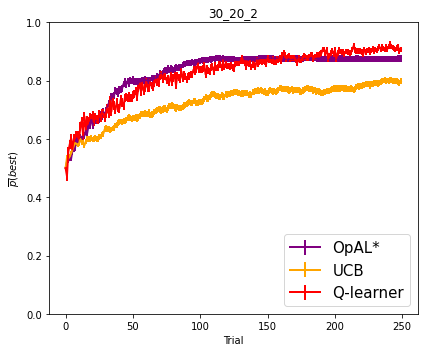

In [7]:
importlib.reload(plot_dynamics)

fig, axs = plt.subplots(figsize=(6, 5))
plot_dynamics.avg_sm(L_states_OpAL_Star,ntrials,n_states,0,axs,"purple")
plot_dynamics.avg_sm(L_Q,ntrials,n_states,0,axs,"orange")
plot_dynamics.avg_sm(L_UCB,ntrials,n_states,0,axs,"red")

plt.legend(("OpAL*", "UCB", "Q-learner"), fontsize = 15, markerscale = 50, loc = 'lower right')
plt.title("30_20_%d" %(complexity))
plt.xlabel("Trial")
plt.ylabel("$\overline{p}(best)$")
plt.ylim([0.,1.])
plt.tight_layout()
plt.ylim([0.,1.])

# Rich

In [8]:
# reproduce optimal learning curve
env = "80_10_%d" %(complexity)
rnd_seeds_OpAL = pickle.load(open("../random_seeds/OpAL/%s_rnd_seeds.pkle" %(env),"rb"))
rnd_seeds_RL = pickle.load(open("../random_seeds/RL/%s_rnd_seeds.pkle" %(env),"rb"))
rnd_seeds_UCB = pickle.load(open("../random_seeds/UCB/%s_rnd_seeds.pkle" %(env),"rb"))

R_states_OpAL_Star = learning.simulate(auc_orders[str_complexity]['SACrit_BayesAnneal_mod'][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
R_states_OpAL_NoHebb = learning.simulate(auc_orders[str_complexity]['NoHebb'][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad, 
        hebb=False)
R_UCB = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=auc_orders[str_complexity]['UCB'][0],rnd_seeds=rnd_seeds_UCB)
R_Q = learn.simulate(auc_orders[str_complexity]['RL'][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)

In [9]:
# run Q with full information
env = "80_10_1" 
R_Q_Full_best = learn.simulate(auc_orders[str_complexity]['RL'][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)
R_UCB_Full_best = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=auc_orders[str_complexity]['UCB'][0],rnd_seeds=rnd_seeds_UCB)


# run Q with full information
env = "70_10_1" 
R_Q_Full_second = learn.simulate(auc_orders[str_complexity]['RL'][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)
R_UCB_Full_second = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=auc_orders[str_complexity]['UCB'][0],rnd_seeds=rnd_seeds_UCB)

(0.0, 1.0)

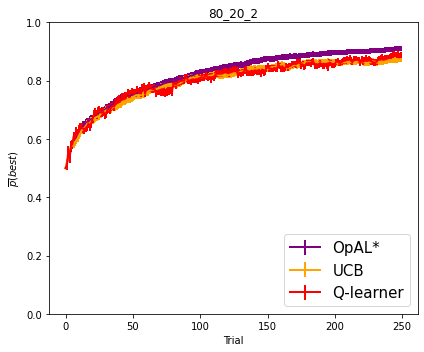

In [10]:
fig, axs = plt.subplots(figsize=(6, 5))
plot_dynamics.avg_sm(R_states_OpAL_Star,ntrials,n_states,0,axs,"purple")
plot_dynamics.avg_sm(R_Q,ntrials,n_states,0,axs,"orange")
plot_dynamics.avg_sm(R_UCB,ntrials,n_states,0,axs,"red")

plt.legend(("OpAL*","UCB", "Q-learner"), fontsize = 15, markerscale = 50, loc = 'lower right')
plt.title("80_20_%d" %(complexity))
plt.xlabel("Trial")
plt.ylabel("$\overline{p}(best)$")
plt.tight_layout()
plt.ylim([0.,1.])

# Convergence analysis

In [11]:
def second_best_q(state):
    '''
    get index of second best Q value, excluding the optimal action
    ''' 

    subset = state.Q[:,1:]
    second_best = np.argmax(subset,axis=1) + 1 # add 1, took away best which is index of 0
    return second_best

def second_best_Act(state):
    '''
    get index of second best Q value, excluding the optimal action
    ''' 

    subset = state.Acts[:,1:]
    second_best = np.argmax(subset,axis=1) + 1 # add 1, took away best which is index of 0
    return second_best

def second_best_V(state):
    '''
    get index of second best V value, excluding the optimal action
    ''' 

    subset = state.V[:,1:]
    second_best = np.argmax(subset,axis=1) + 1 # add 1, took away best which is index of 0
    return second_best

def second_best_SM(state):
    '''
    get index of second best SM value, excluding the optimal action
    ''' 

    subset = state.SM[:,1:]
    second_best = np.argmax(subset,axis=1) + 1 # add 1, took away best which is index of 0
    return second_best

def softmax(A,B):
    '''
    softmax of p(A) with binary choice A/B
    '''

    # multioption softmax (invariant to constant offsets)
    arr_options = np.array([A,B])
    Act = arr_options - np.max(arr_options)
    expAct = np.exp(Act)
    ps = expAct/np.sum(expAct)
    
    return ps[0]
    

# q plots

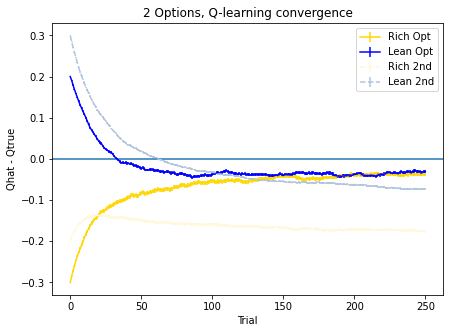

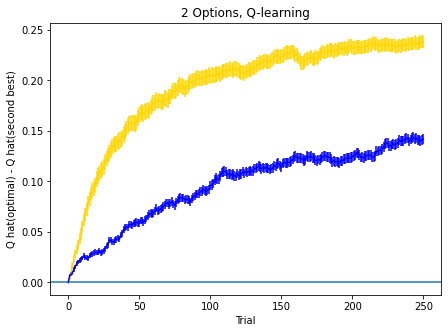

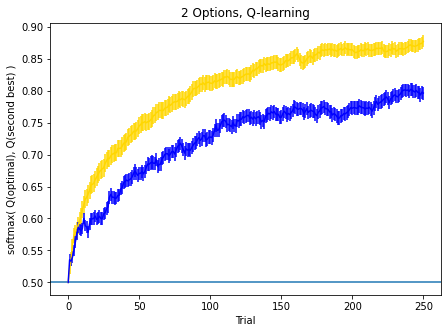

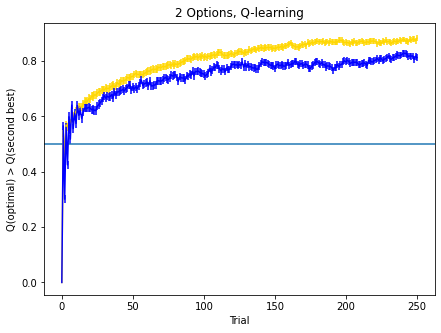

In [12]:
# Q-learning plots 
r_convergence = np.zeros([n_states,ntrials+1])
l_convergence = np.zeros([n_states,ntrials+1])

r_convergence_second = np.zeros([n_states,ntrials+1])
l_convergence_second = np.zeros([n_states,ntrials+1])

r_SM = np.zeros([n_states,ntrials+1])
l_SM = np.zeros([n_states,ntrials+1])

r_ag = np.zeros([n_states,ntrials+1])
l_ag = np.zeros([n_states,ntrials+1])

r_order = np.zeros([n_states,ntrials+1])
l_order = np.zeros([n_states,ntrials+1])
for i in np.arange(n_states):
     # difference from ground truth for optimal action
    r_state = R_Q[i]
    r_err = r_state.Q[:,0] - .8    
    r_convergence[i,:] = r_err

    l_state = L_Q[i]
    l_err = l_state.Q[:,0] - .3
    l_convergence[i,:] = l_err

    # second best option
    r_second_best = second_best_q(r_state)
    r_err = np.array([r_state.Q[idx,second] for idx,second in enumerate(r_second_best)]) - .7
    r_convergence_second[i,:] = r_err

    l_second_best = second_best_q(l_state)
    l_err = np.array([l_state.Q[idx,second] for idx,second in enumerate(l_second_best)]) - .2
    l_convergence_second[i,:] = l_err

    # action gap
    beta = r_state.beta # same for both env
    r_SM[i,:] = np.array([softmax(beta*r_state.Q[idx,0],beta*r_state.Q[idx,second]) for idx,second in enumerate(r_second_best)]) 
    l_SM[i,:] = np.array([softmax(beta*l_state.Q[idx,0],beta*l_state.Q[idx,second]) for idx,second in enumerate(l_second_best)]) 
    
    r_ag[i,:] = np.array([(r_state.Q[idx,0] - r_state.Q[idx,second]) for idx,second in enumerate(r_second_best)]) 
    l_ag[i,:] = np.array([(l_state.Q[idx,0] - l_state.Q[idx,second]) for idx,second in enumerate(l_second_best)]) 

    r_order[i,:] = np.array([int(r_state.Q[idx,0] > r_state.Q[idx,second]) for idx,second in enumerate(r_second_best)]) 
    l_order[i,:] = np.array([int(l_state.Q[idx,0] > l_state.Q[idx,second]) for idx,second in enumerate(l_second_best)]) 
    

Q_r_conv_mean = np.mean(r_convergence,axis=0)
Q_r_conv_sem = stats.sem(r_convergence)
Q_l_conv_mean = np.mean(l_convergence,axis=0)
Q_l_conv_sem = stats.sem(l_convergence)

# second best
Q_r_conv_sec_mean = np.mean(r_convergence_second,axis=0)
Q_r_conv_sec_sem = stats.sem(r_convergence_second)
Q_l_conv_sec_mean = np.mean(l_convergence_second,axis=0)
Q_l_conv_sec_sem = stats.sem(l_convergence_second)


# plt the things
xaxis = np.arange(ntrials+1)
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, Q-learning convergence" %(complexity))
axs.set_ylabel("Qhat - Qtrue")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,Q_r_conv_mean,yerr=Q_r_conv_sem, c = "gold")
axs.errorbar(xaxis,Q_l_conv_mean,yerr=Q_l_conv_sem, c = "blue")
axs.errorbar(xaxis,Q_r_conv_sec_mean,yerr=Q_r_conv_sec_sem, c = "cornsilk", linestyle = "dashed")
axs.errorbar(xaxis,Q_l_conv_sec_mean,yerr=Q_l_conv_sec_sem, c = "lightsteelblue", linestyle = "dashed")
axs.legend(["Rich Opt","Lean Opt","Rich 2nd","Lean 2nd"])
axs.axhline(y=0)


# true action gap 
Q_r_ag_mean = np.mean(r_ag,axis=0)
Q_r_ag_sem = stats.sem(r_ag)
Q_l_ag_mean = np.mean(l_ag,axis=0)
Q_l_ag_sem = stats.sem(l_ag)


fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, Q-learning" %(complexity))
axs.set_ylabel("Q hat(optimal) - Q hat(second best)")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,Q_r_ag_mean,yerr=Q_r_ag_sem, c = "gold")
axs.errorbar(xaxis,Q_l_ag_mean,yerr=Q_l_ag_sem, c = "blue")
axs.axhline(y=0)


# SM action gap 
Q_r_SM_mean = np.mean(r_SM,axis=0)
Q_r_SM_sem = stats.sem(r_SM)
Q_l_SM_mean = np.mean(l_SM,axis=0)
Q_l_SM_sem = stats.sem(l_SM)


fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, Q-learning" %(complexity))
axs.set_ylabel("softmax( Q(optimal), Q(second best) )")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,Q_r_SM_mean,yerr=Q_r_SM_sem, c = "gold")
axs.errorbar(xaxis,Q_l_SM_mean,yerr=Q_l_SM_sem, c = "blue")
axs.axhline(y=0.5)



# order
Q_r_order_mean = np.mean(r_order,axis=0)
Q_r_order_sem = stats.sem(r_order)
Q_l_order_mean = np.mean(l_order,axis=0)
Q_l_order_sem = stats.sem(l_order)


fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, Q-learning" %(complexity))
axs.set_ylabel("Q(optimal) > Q(second best)")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,Q_r_order_mean,yerr=Q_r_order_sem, c = "gold")
axs.errorbar(xaxis,Q_l_order_mean,yerr=Q_l_order_sem, c = "blue")
axs.axhline(y=0.5)
# axs.set_ylim([0.5,1.0])


# Q-full info

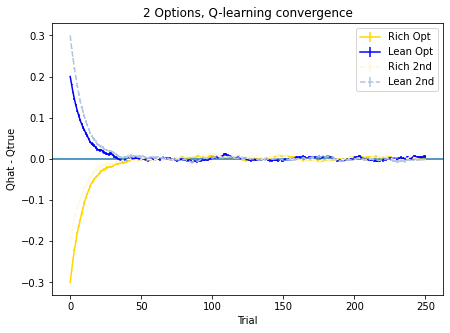

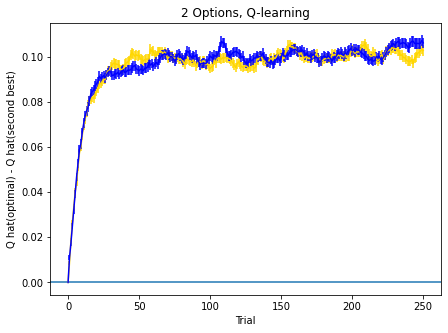

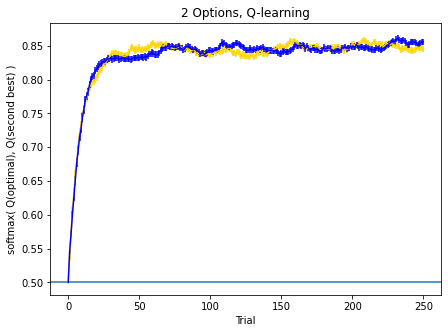

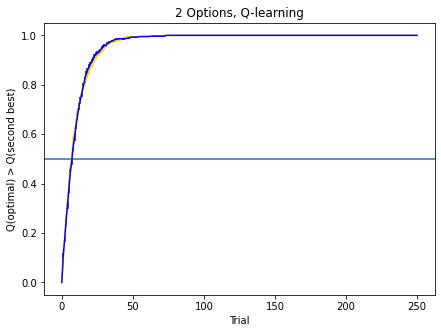

In [13]:
# Q-learning plots 
r_convergence = np.zeros([n_states,ntrials+1])
l_convergence = np.zeros([n_states,ntrials+1])

r_convergence_second = np.zeros([n_states,ntrials+1])
l_convergence_second = np.zeros([n_states,ntrials+1])

r_SM = np.zeros([n_states,ntrials+1])
l_SM = np.zeros([n_states,ntrials+1])

r_ag = np.zeros([n_states,ntrials+1])
l_ag = np.zeros([n_states,ntrials+1])

r_order = np.zeros([n_states,ntrials+1])
l_order = np.zeros([n_states,ntrials+1])
for i in np.arange(n_states):
     # difference from ground truth for optimal action
    r_state = R_Q_Full_best[i]
    r_err = r_state.Q[:,0] - .8    
    r_convergence[i,:] = r_err

    l_state = L_Q_Full_best[i]
    l_err = l_state.Q[:,0] - .3
    l_convergence[i,:] = l_err

    # second best option
    r_second_best = R_Q_Full_second[i]
    r_err = r_second_best.Q[:,0] - .7
    r_convergence_second[i,:] = r_err

    l_second_best = L_Q_Full_second[i]
    l_err = l_second_best.Q[:,0] - .2
    l_convergence_second[i,:] = l_err

    # action gap
    beta = r_state.beta # same for both env
    r_SM[i,:] = np.array([softmax(beta*r_state.Q[idx,0],beta*r_second_best.Q[idx,0]) for idx in range(ntrials+1)]) 
    l_SM[i,:] = np.array([softmax(beta*l_state.Q[idx,0],beta*l_second_best.Q[idx,0]) for idx in range(ntrials+1)]) 
    
    r_ag[i,:] = np.array([(r_state.Q[idx,0] - r_second_best.Q[idx,0]) for idx in range(ntrials+1)]) 
    l_ag[i,:] = np.array([(l_state.Q[idx,0] - l_second_best.Q[idx,0]) for idx in range(ntrials+1)]) 

    r_order[i,:] = np.array([int(r_state.Q[idx,0] > r_second_best.Q[idx,0]) for idx in range(ntrials+1)]) 
    l_order[i,:] = np.array([int(l_state.Q[idx,0] > l_second_best.Q[idx,0]) for idx in range(ntrials+1)]) 
    

Q_FULL_r_conv_mean = np.mean(r_convergence,axis=0)
Q_FULL_r_conv_sem = stats.sem(r_convergence)
Q_FULL_l_conv_mean = np.mean(l_convergence,axis=0)
Q_FULL_l_conv_sem = stats.sem(l_convergence)

# second best
Q_FULL_r_conv_sec_mean = np.mean(r_convergence_second,axis=0)
Q_FULL_r_conv_sec_sem = stats.sem(r_convergence_second)
Q_FULL_l_conv_sec_mean = np.mean(l_convergence_second,axis=0)
Q_FULL_l_conv_sec_sem = stats.sem(l_convergence_second)


# plt the things
xaxis = np.arange(ntrials+1)
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, Q-learning convergence" %(complexity))
axs.set_ylabel("Qhat - Qtrue")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,Q_FULL_r_conv_mean,yerr=Q_FULL_r_conv_sem, c = "gold")
axs.errorbar(xaxis,Q_FULL_l_conv_mean,yerr=Q_FULL_l_conv_sem, c = "blue")
axs.errorbar(xaxis,Q_FULL_r_conv_sec_mean,yerr=Q_FULL_r_conv_sec_sem, c = "cornsilk", linestyle = "dashed")
axs.errorbar(xaxis,Q_FULL_l_conv_sec_mean,yerr=Q_FULL_l_conv_sec_sem, c = "lightsteelblue", linestyle = "dashed")
axs.legend(["Rich Opt","Lean Opt","Rich 2nd","Lean 2nd"])
axs.axhline(y=0)


# true action gap 
Q_FULL_r_ag_mean = np.mean(r_ag,axis=0)
Q_FULL_r_ag_sem = stats.sem(r_ag)
Q_FULL_l_ag_mean = np.mean(l_ag,axis=0)
Q_FULL_l_ag_sem = stats.sem(l_ag)


fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, Q-learning" %(complexity))
axs.set_ylabel("Q hat(optimal) - Q hat(second best)")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,Q_FULL_r_ag_mean,yerr=Q_FULL_r_ag_sem, c = "gold")
axs.errorbar(xaxis,Q_FULL_l_ag_mean,yerr=Q_FULL_l_ag_sem, c = "blue")
axs.axhline(y=0)


# SM action gap 
Q_FULL_r_SM_mean = np.mean(r_SM,axis=0)
Q_FULL_r_SM_sem = stats.sem(r_SM)
Q_FULL_l_SM_mean = np.mean(l_SM,axis=0)
Q_FULL_l_SM_sem = stats.sem(l_SM)


fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, Q-learning" %(complexity))
axs.set_ylabel("softmax( Q(optimal), Q(second best) )")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,Q_FULL_r_SM_mean,yerr=Q_FULL_r_SM_sem, c = "gold")
axs.errorbar(xaxis,Q_FULL_l_SM_mean,yerr=Q_FULL_l_SM_sem, c = "blue")
axs.axhline(y=0.5)



# order
Q_FULL_r_order_mean = np.mean(r_order,axis=0)
Q_FULL_r_order_sem = stats.sem(r_order)
Q_FULL_l_order_mean = np.mean(l_order,axis=0)
Q_FULL_l_order_sem = stats.sem(l_order)


fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, Q-learning" %(complexity))
axs.set_ylabel("Q(optimal) > Q(second best)")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,Q_FULL_r_order_mean,yerr=Q_FULL_r_order_sem, c = "gold")
axs.errorbar(xaxis,Q_FULL_l_order_mean,yerr=Q_FULL_l_order_sem, c = "blue")
axs.axhline(y=0.5)
# axs.set_ylim([0.5,1.1])


# OpAL*

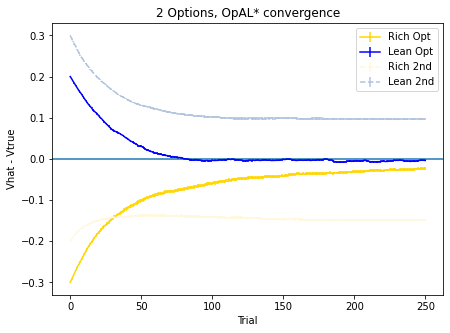

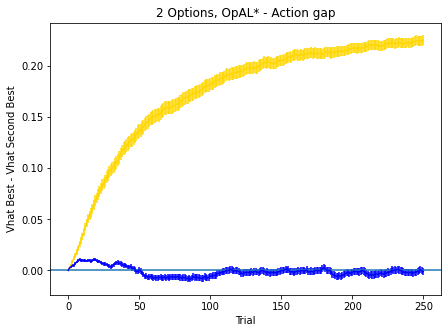

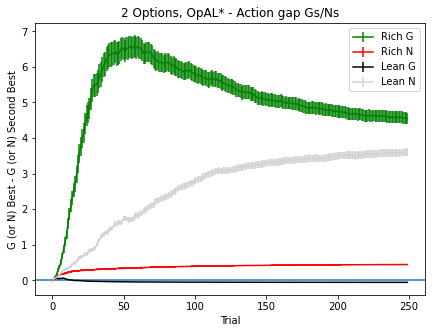

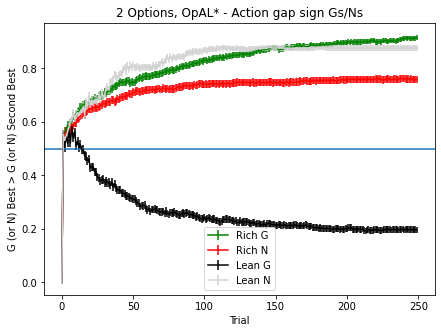

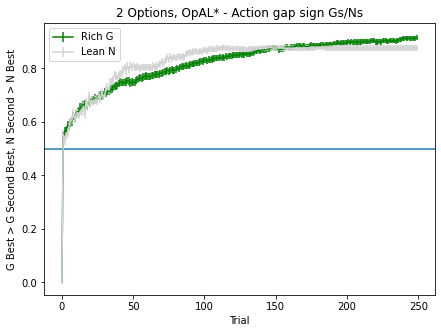

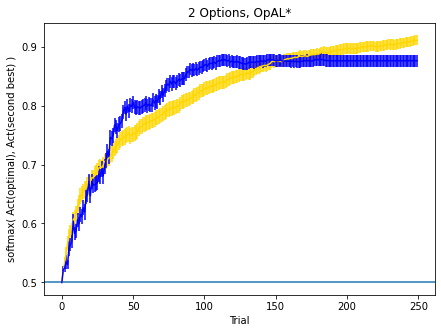

In [14]:
# OpAL* plots 

r_convergence = np.zeros([n_states,ntrials+1])
l_convergence = np.zeros([n_states,ntrials+1])

r_convergence_second = np.zeros([n_states,ntrials+1])
l_convergence_second = np.zeros([n_states,ntrials+1])

r_ag_V = np.zeros([n_states,ntrials+1])
l_ag_V = np.zeros([n_states,ntrials+1])

# gs and ns
r_Gs = np.zeros([n_states,ntrials+1])
r_Ns = np.zeros([n_states,ntrials+1])
l_Gs = np.zeros([n_states,ntrials+1])
l_Ns = np.zeros([n_states,ntrials+1])

r_Gs_second = np.zeros([n_states,ntrials])
r_Ns_second = np.zeros([n_states,ntrials])
l_Gs_second = np.zeros([n_states,ntrials])
l_Ns_second = np.zeros([n_states,ntrials])

r_ag_G = np.zeros([n_states,ntrials])
r_ag_N = np.zeros([n_states,ntrials])
l_ag_G = np.zeros([n_states,ntrials])
l_ag_N = np.zeros([n_states,ntrials])

r_SM = np.zeros([n_states,ntrials])
l_SM = np.zeros([n_states,ntrials])

r_order_G = np.zeros([n_states,ntrials])
l_order_G = np.zeros([n_states,ntrials])
r_order_N = np.zeros([n_states,ntrials])
l_order_N = np.zeros([n_states,ntrials])


for i in np.arange(n_states):
    r_state = R_states_OpAL_Star[i]
    r_err =  r_state.V[:,0] - .8     # difference from ground truth
    r_convergence[i,:] = r_err

    l_state = L_states_OpAL_Star[i]
    l_err = l_state.V[:,0] - .3
    l_convergence[i,:] = l_err

    # store Gs and Ns
    r_Gs[i,:] = r_state.QG[:,0]
    r_Ns[i,:] = r_state.QN[:,0]
    l_Gs[i,:] = l_state.QG[:,0]
    l_Ns[i,:] = l_state.QN[:,0]

     # second best option
    r_second_best = second_best_V(r_state)
    r_err = np.array([r_state.V[idx,second] for idx,second in enumerate(r_second_best)]) - .7
    r_convergence_second[i,:] = r_err

    l_second_best = second_best_V(l_state)
    l_err = np.array([l_state.V[idx,second] for idx,second in enumerate(l_second_best)]) - .2
    l_convergence_second[i,:] = l_err

    # action gap - V
    r_ag_V[i,:] = np.array([r_state.V[idx,0] - r_state.V[idx,second] for idx,second in enumerate(r_second_best)]) 
    l_ag_V[i,:] = np.array([l_state.V[idx,0] - l_state.V[idx,second] for idx,second in enumerate(l_second_best)]) 

    # second best SM
    r_second_SM = second_best_SM(r_state)
    l_second_SM = second_best_SM(l_state)

    r_Gs_second[i,:] = np.array([r_state.QG[idx,second] for idx,second in enumerate(r_second_SM)]) 
    r_Ns_second[i,:] = np.array([r_state.QN[idx,second] for idx,second in enumerate(r_second_SM)]) 
    l_Gs_second[i,:] = np.array([l_state.QG[idx,second] for idx,second in enumerate(l_second_SM)])
    l_Ns_second[i,:] = np.array([l_state.QN[idx,second] for idx,second in enumerate(l_second_SM)]) 

    # Action gap G: Best(G) - Second(G)
    r_ag_G[i,:] = (r_Gs[i,0:ntrials] - r_Gs_second[i,:])
    l_ag_G[i,:] = (l_Gs[i,0:ntrials] - l_Gs_second[i,:])

    # Action gap N: Best(N) - Second(N)
    r_ag_N[i,:] = (r_Ns_second[i,:] - r_Ns[i,0:ntrials])
    l_ag_N[i,:] = (l_Ns_second[i,:] - l_Ns[i,0:ntrials])

    # only consider ordering
    r_order_G[i,:] = [1 if item > 0 else 0 for item in r_ag_G[i,:]]
    l_order_G[i,:] = [1 if item > 0 else 0 for item in l_ag_G[i,:]]
    r_order_N[i,:] = [1 if item > 0 else 0 for item in r_ag_N[i,:]]
    l_order_N[i,:] = [1 if item > 0 else 0 for item in l_ag_N[i,:]]

    # Act
    r_beta_g = r_state.beta_g
    r_beta_n = r_state.beta_n
    l_beta_g = l_state.beta_g
    l_beta_n = l_state.beta_n

    r_act = r_beta_g*r_Gs[i,0:ntrials] - r_beta_n*r_Ns[i,0:ntrials]
    r_act_second = r_beta_g*r_Gs_second[i,0:ntrials] - r_beta_n*r_Ns_second[i,0:ntrials]
    l_act = l_beta_g*l_Gs[i,0:ntrials] - l_beta_n*l_Ns[i,0:ntrials]
    l_act_second = l_beta_g*l_Gs_second[i,0:ntrials] - l_beta_n*l_Ns_second[i,0:ntrials]

    r_SM[i,:] = np.array([softmax(r_act[idx],r_act_second[idx]) for idx in np.arange(ntrials)])
    l_SM[i,:] = np.array([softmax(l_act[idx],l_act_second[idx]) for idx in np.arange(ntrials)])

    
r_conv_mean = np.mean(r_convergence,axis=0)
r_conv_sem = stats.sem(r_convergence)
l_conv_mean = np.mean(l_convergence,axis=0)
l_conv_sem = stats.sem(l_convergence)

# second best
r_conv_sec_mean = np.mean(r_convergence_second,axis=0)
r_conv_sec_sem = stats.sem(r_convergence_second)
l_conv_sec_mean = np.mean(l_convergence_second,axis=0)
l_conv_sec_sem = stats.sem(l_convergence_second)


# plt the things
xaxis = np.arange(ntrials+1)
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, OpAL* convergence" %(complexity))
axs.set_ylabel("Vhat - Vtrue")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,r_conv_mean,yerr=r_conv_sem, c = "gold")
axs.errorbar(xaxis,l_conv_mean,yerr=l_conv_sem, c = "blue")
axs.errorbar(xaxis,r_conv_sec_mean,yerr=r_conv_sec_sem, c = "cornsilk", linestyle = "dashed")
axs.errorbar(xaxis,l_conv_sec_mean,yerr=l_conv_sec_sem, c = "lightsteelblue", linestyle = "dashed")
axs.legend(["Rich Opt","Lean Opt","Rich 2nd","Lean 2nd"])
axs.axhline(y=0)


# action gap 
r_ag_mean = np.mean(r_ag_V,axis=0)
r_ag_sem = stats.sem(r_ag_V)
l_ag_mean = np.mean(l_ag_V,axis=0)
l_ag_sem = stats.sem(l_ag_V)


fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, OpAL* - Action gap" %(complexity))
axs.set_ylabel("Vhat Best - Vhat Second Best")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,r_ag_mean,yerr=r_ag_sem, c = "gold")
axs.errorbar(xaxis,l_ag_mean,yerr=l_ag_sem, c = "blue")
axs.axhline(y=0)

# action gap - G/N
r_ag_G_mean = np.mean(r_ag_G,axis=0)
r_ag_G_sem = stats.sem(r_ag_G)
l_ag_G_mean = np.mean(l_ag_G,axis=0)
l_ag_G_sem = stats.sem(l_ag_G)

r_ag_N_mean = np.mean(r_ag_N,axis=0)
r_ag_N_sem = stats.sem(r_ag_N)
l_ag_N_mean = np.mean(l_ag_N,axis=0)
l_ag_N_sem = stats.sem(l_ag_N)

xaxis = np.arange(ntrials)
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, OpAL* - Action gap Gs/Ns" %(complexity))
axs.set_ylabel("G (or N) Best - G (or N) Second Best")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,r_ag_G_mean,yerr=r_ag_G_sem, c = "green")
axs.errorbar(xaxis,r_ag_N_mean,yerr=r_ag_N_sem, c = "red")
axs.errorbar(xaxis,l_ag_G_mean,yerr=l_ag_G_sem, c = "black")
axs.errorbar(xaxis,l_ag_N_mean,yerr=l_ag_N_sem, c = "lightgrey")
axs.legend(["Rich G","Rich N","Lean G","Lean N"])
axs.axhline(y=0)

# action gap - G/N sign
r_order_G_mean = np.mean(r_order_G,axis=0)
r_order_G_sem = stats.sem(r_order_G)
l_order_G_mean = np.mean(l_order_G,axis=0)
l_order_G_sem = stats.sem(l_order_G)

r_order_N_mean = np.mean(r_order_N,axis=0)
r_order_N_sem = stats.sem(r_order_N)
l_order_N_mean = np.mean(l_order_N,axis=0)
l_order_N_sem = stats.sem(l_order_N)

xaxis = np.arange(ntrials)
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, OpAL* - Action gap sign Gs/Ns" %(complexity))
axs.set_ylabel("G (or N) Best > G (or N) Second Best")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,r_order_G_mean,yerr=r_order_G_sem, c = "green")
axs.errorbar(xaxis,r_order_N_mean,yerr=r_order_N_sem, c = "red")
axs.errorbar(xaxis,l_order_G_mean,yerr=l_order_G_sem, c = "black")
axs.errorbar(xaxis,l_order_N_mean,yerr=l_order_N_sem, c = "lightgrey")
axs.legend(["Rich G","Rich N","Lean G","Lean N"])
axs.axhline(y=0.5)

xaxis = np.arange(ntrials)
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, OpAL* - Action gap sign Gs/Ns" %(complexity))
axs.set_ylabel("G Best > G Second Best, N Second > N Best")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,r_order_G_mean,yerr=r_order_G_sem, c = "green")
axs.errorbar(xaxis,l_order_N_mean,yerr=l_order_N_sem, c = "lightgrey")
axs.legend(["Rich G","Lean N"])
axs.axhline(y=0.5)
# axs.set_ylim([0.5,1.0])

# softmax
r_SM_mean = np.mean(r_SM,axis=0)
r_SM_sem = stats.sem(r_SM)
l_SM_mean = np.mean(l_SM,axis=0)
l_SM_sem = stats.sem(l_SM)

xaxis = np.arange(ntrials)
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, OpAL*" %(complexity))
axs.set_ylabel("softmax( Act(optimal), Act(second best) )")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,r_SM_mean,yerr=r_SM_sem, c = "gold")
axs.errorbar(xaxis,l_SM_mean,yerr=l_SM_sem, c = "blue")
axs.axhline(y=0.5)


# Organize for paper figure

Text(0.5, 1.0, 'Q-learning convergence is \n impeded by stochastic sampling')

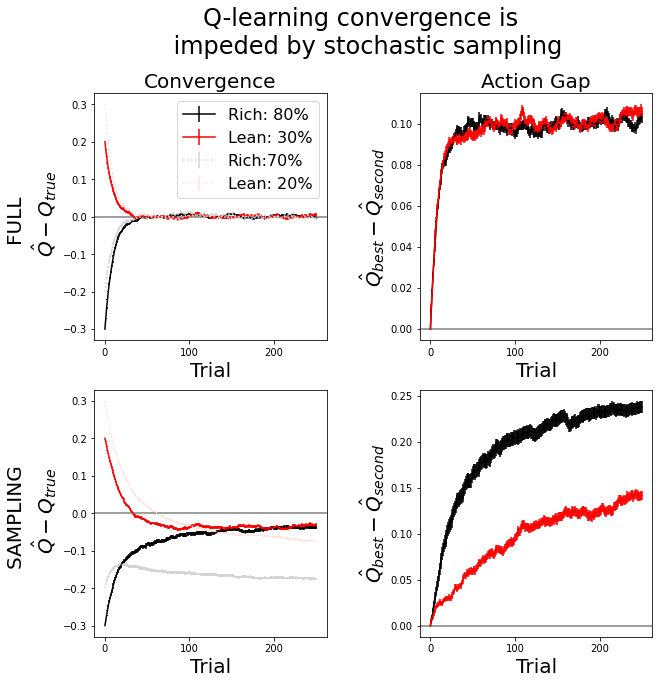

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.dpi'] = 500

fill_me = axs[0,0] # axs[row,col]
xaxis = np.arange(ntrials+1)
fill_me.set_title("Convergence", fontsize=20)
fill_me.set_ylabel("FULL \n $\^{Q} - Q_{true}$", fontsize=20)
fill_me.set_xlabel("Trial", fontsize=20)
fill_me.errorbar(xaxis,Q_FULL_r_conv_mean,yerr=Q_FULL_r_conv_sem, c = "black")
fill_me.errorbar(xaxis,Q_FULL_l_conv_mean,yerr=Q_FULL_l_conv_sem, c = "red")
fill_me.errorbar(xaxis,Q_FULL_r_conv_sec_mean,yerr=Q_FULL_r_conv_sec_sem, c = "lightgrey", linestyle="dotted")
fill_me.errorbar(xaxis,Q_FULL_l_conv_sec_mean,yerr=Q_FULL_l_conv_sec_sem, c = "mistyrose", linestyle="dotted")
fill_me.legend(["Rich: 80%","Lean: 30%","Rich:70%","Lean: 20%"],fontsize=16)
fill_me.axhline(y=0, color="grey")

fill_me = axs[1,0] # axs[row,col]
xaxis = np.arange(ntrials+1)
# fill_me.set_title("Q-learning, %d Options" %(complexity))
fill_me.set_ylabel("SAMPLING \n $\^{Q} - Q_{true}$", fontsize=20)
fill_me.set_xlabel("Trial", fontsize=20)
fill_me.errorbar(xaxis,Q_r_conv_mean,yerr=Q_r_conv_sem, c = "black")
fill_me.errorbar(xaxis,Q_l_conv_mean,yerr=Q_l_conv_sem, c = "red")
fill_me.errorbar(xaxis,Q_r_conv_sec_mean,yerr=Q_r_conv_sec_sem, c = "lightgrey", linestyle="dotted")
fill_me.errorbar(xaxis,Q_l_conv_sec_mean,yerr=Q_l_conv_sec_sem, c = "mistyrose", linestyle="dotted")
# fill_me.legend(["Rich Opt","Lean Opt","Rich 2nd","Lean 2nd"])
fill_me.axhline(y=0, color="grey")

fill_me = axs[0,1] # axs[row,col]
fill_me.set_title("Action Gap", fontsize=20)
fill_me.set_ylabel("$\^{Q}_{best} - \^{Q}_{second}$", fontsize=20)
fill_me.set_xlabel("Trial", fontsize=20)
fill_me.errorbar(xaxis,Q_FULL_r_ag_mean,yerr=Q_FULL_r_ag_sem, c = "black")
fill_me.errorbar(xaxis,Q_FULL_l_ag_mean,yerr=Q_FULL_l_ag_sem, c = "red")
fill_me.axhline(y=0, color="grey")

fill_me = axs[1,1] # axs[row,col]
fill_me.set_ylabel("$\^{Q}_{best} - \^{Q}_{second}$", fontsize=20)
fill_me.set_xlabel("Trial", fontsize=20)
fill_me.errorbar(xaxis,Q_r_ag_mean,yerr=Q_r_ag_sem, c = "black")
fill_me.errorbar(xaxis,Q_l_ag_mean,yerr=Q_l_ag_sem, c = "red")
fill_me.axhline(y=0,color="grey")

plt.subplots_adjust(wspace=0.4)
fig.suptitle('Q-learning convergence is \n impeded by stochastic sampling', y=1.0, fontsize=24)


Text(0.5, 1.0, 'OpAL* G/N specialties improve\n cross-environment policy')

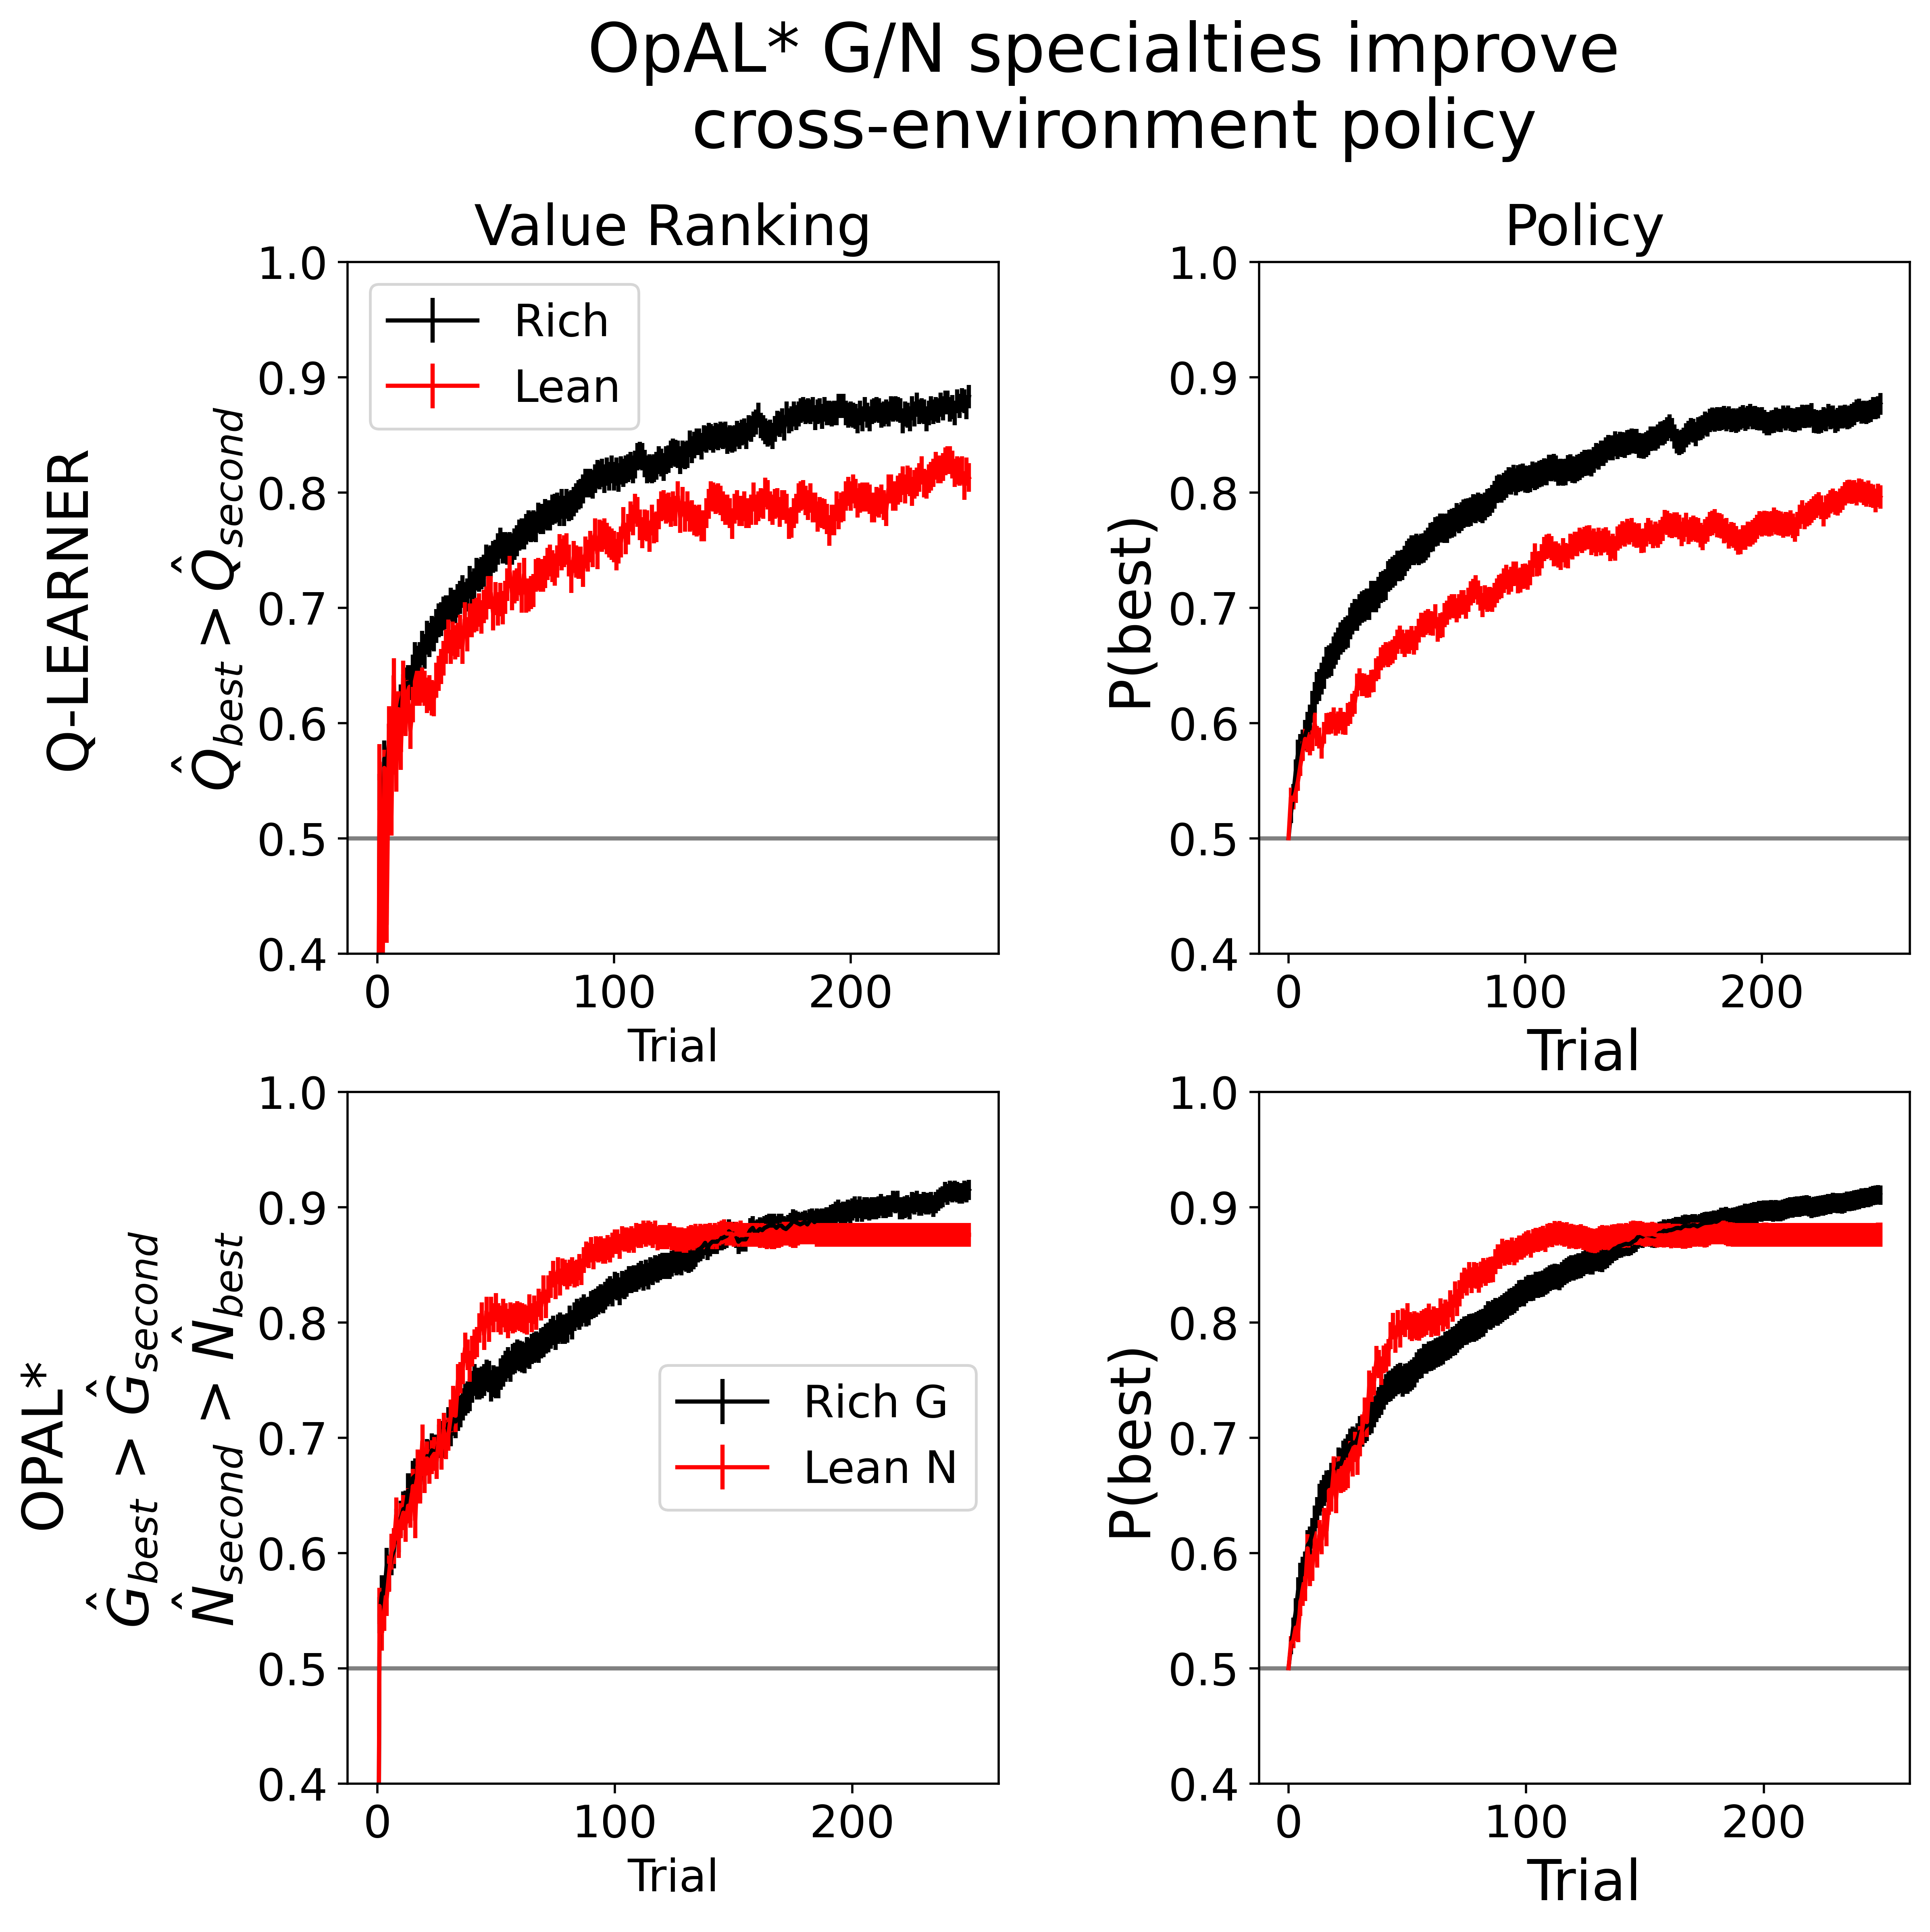

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(10, 10))
plt.rcParams.update({'font.size': 16})

if complexity == 6:
    lim = [0.,.8]
else:
    lim = [.4,1.0]

fill_me = axs[0,0] # axs[row,col]
xaxis = np.arange(ntrials+1)
fill_me.set_title("Value Ranking", fontsize=20)
fill_me.set_ylabel("Q-LEARNER\n \n $\^{Q}_{best} > \^{Q}_{second}$", fontsize=20)
fill_me.set_xlabel("Trial")
fill_me.errorbar(xaxis,Q_r_order_mean,yerr=Q_r_order_sem, c = "black")
fill_me.errorbar(xaxis,Q_l_order_mean,yerr=Q_l_order_sem, c = "red")
fill_me.legend(["Rich","Lean"],fontsize=16)
fill_me.axhline(y=0.5, color="grey")
fill_me.set_ylim(lim)

fill_me = axs[1,0] # axs[row,col]
xaxis = np.arange(ntrials)
fill_me.set_ylabel("OPAL* \n $\^{G}_{best}$ > $\^{G}_{second}$ \n $\^{N}_{second}$ > $\^{N}_{best}$", fontsize=20)
fill_me.set_xlabel("Trial")
fill_me.errorbar(xaxis,r_order_G_mean,yerr=r_order_G_sem, c = "black")
fill_me.errorbar(xaxis,l_order_N_mean,yerr=l_order_N_sem, c = "red")
fill_me.legend(["Rich G","Lean N"],fontsize=16)
fill_me.axhline(y=0.5, color="grey")
fill_me.set_ylim(lim)

xaxis = np.arange(ntrials+1)
fill_me = axs[0,1] # axs[row,col]
fill_me.set_title("Policy", fontsize=20)
fill_me.set_ylabel("P(best)", fontsize=20)
fill_me.set_xlabel("Trial", fontsize=20)
fill_me.errorbar(xaxis,Q_r_SM_mean,yerr=Q_r_SM_sem, c = "black")
fill_me.errorbar(xaxis,Q_l_SM_mean,yerr=Q_l_SM_sem, c = "red")
fill_me.axhline(y=0.5, color="grey")
fill_me.set_ylim(lim)

fill_me = axs[1,1] # axs[row,col]
xaxis = np.arange(ntrials)
fill_me.set_ylabel("P(best)", fontsize=20)
fill_me.set_xlabel("Trial", fontsize=20)
fill_me.errorbar(xaxis,r_SM_mean,yerr=r_SM_sem, c = "black")
fill_me.errorbar(xaxis,l_SM_mean,yerr=l_SM_sem, c = "red")
fill_me.axhline(y=0.5,color="grey")
fill_me.set_ylim(lim)


plt.subplots_adjust(wspace=0.4)
fig.suptitle('OpAL* G/N specialties improve\n cross-environment policy', y=1.0,fontsize=24)


# Convergence for UCB

### UCB - sampling

(0.0, 1.0)

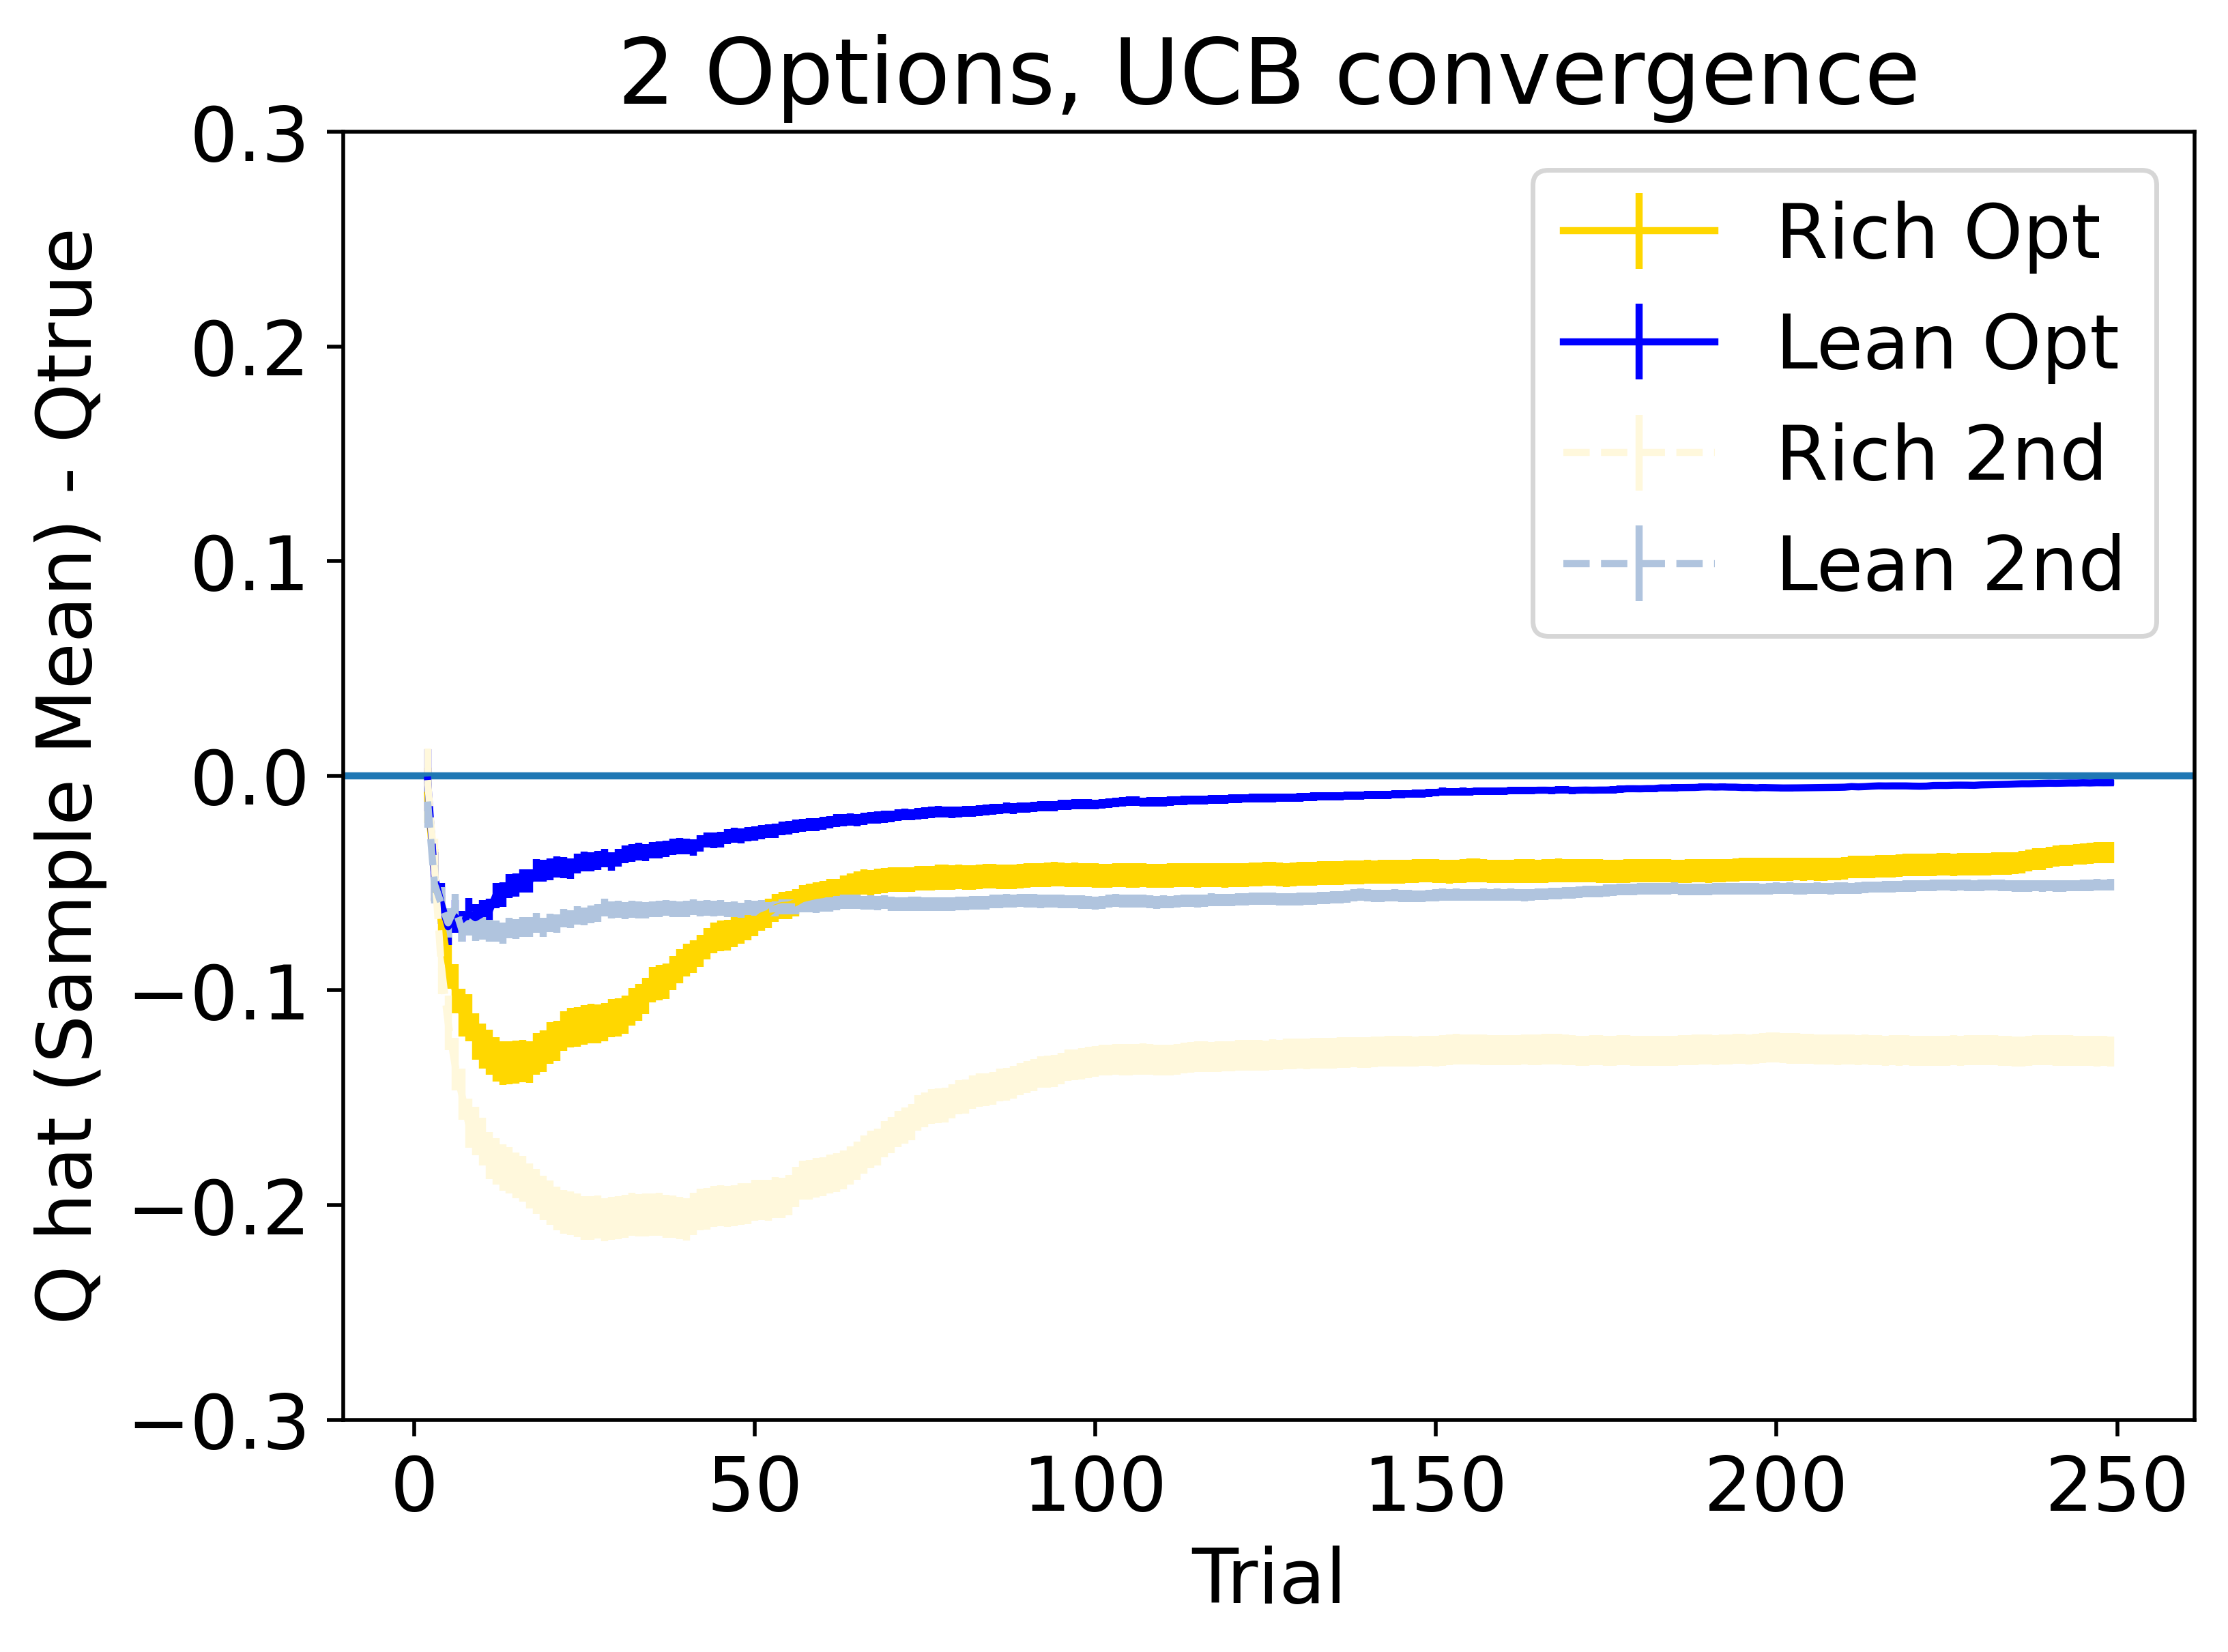

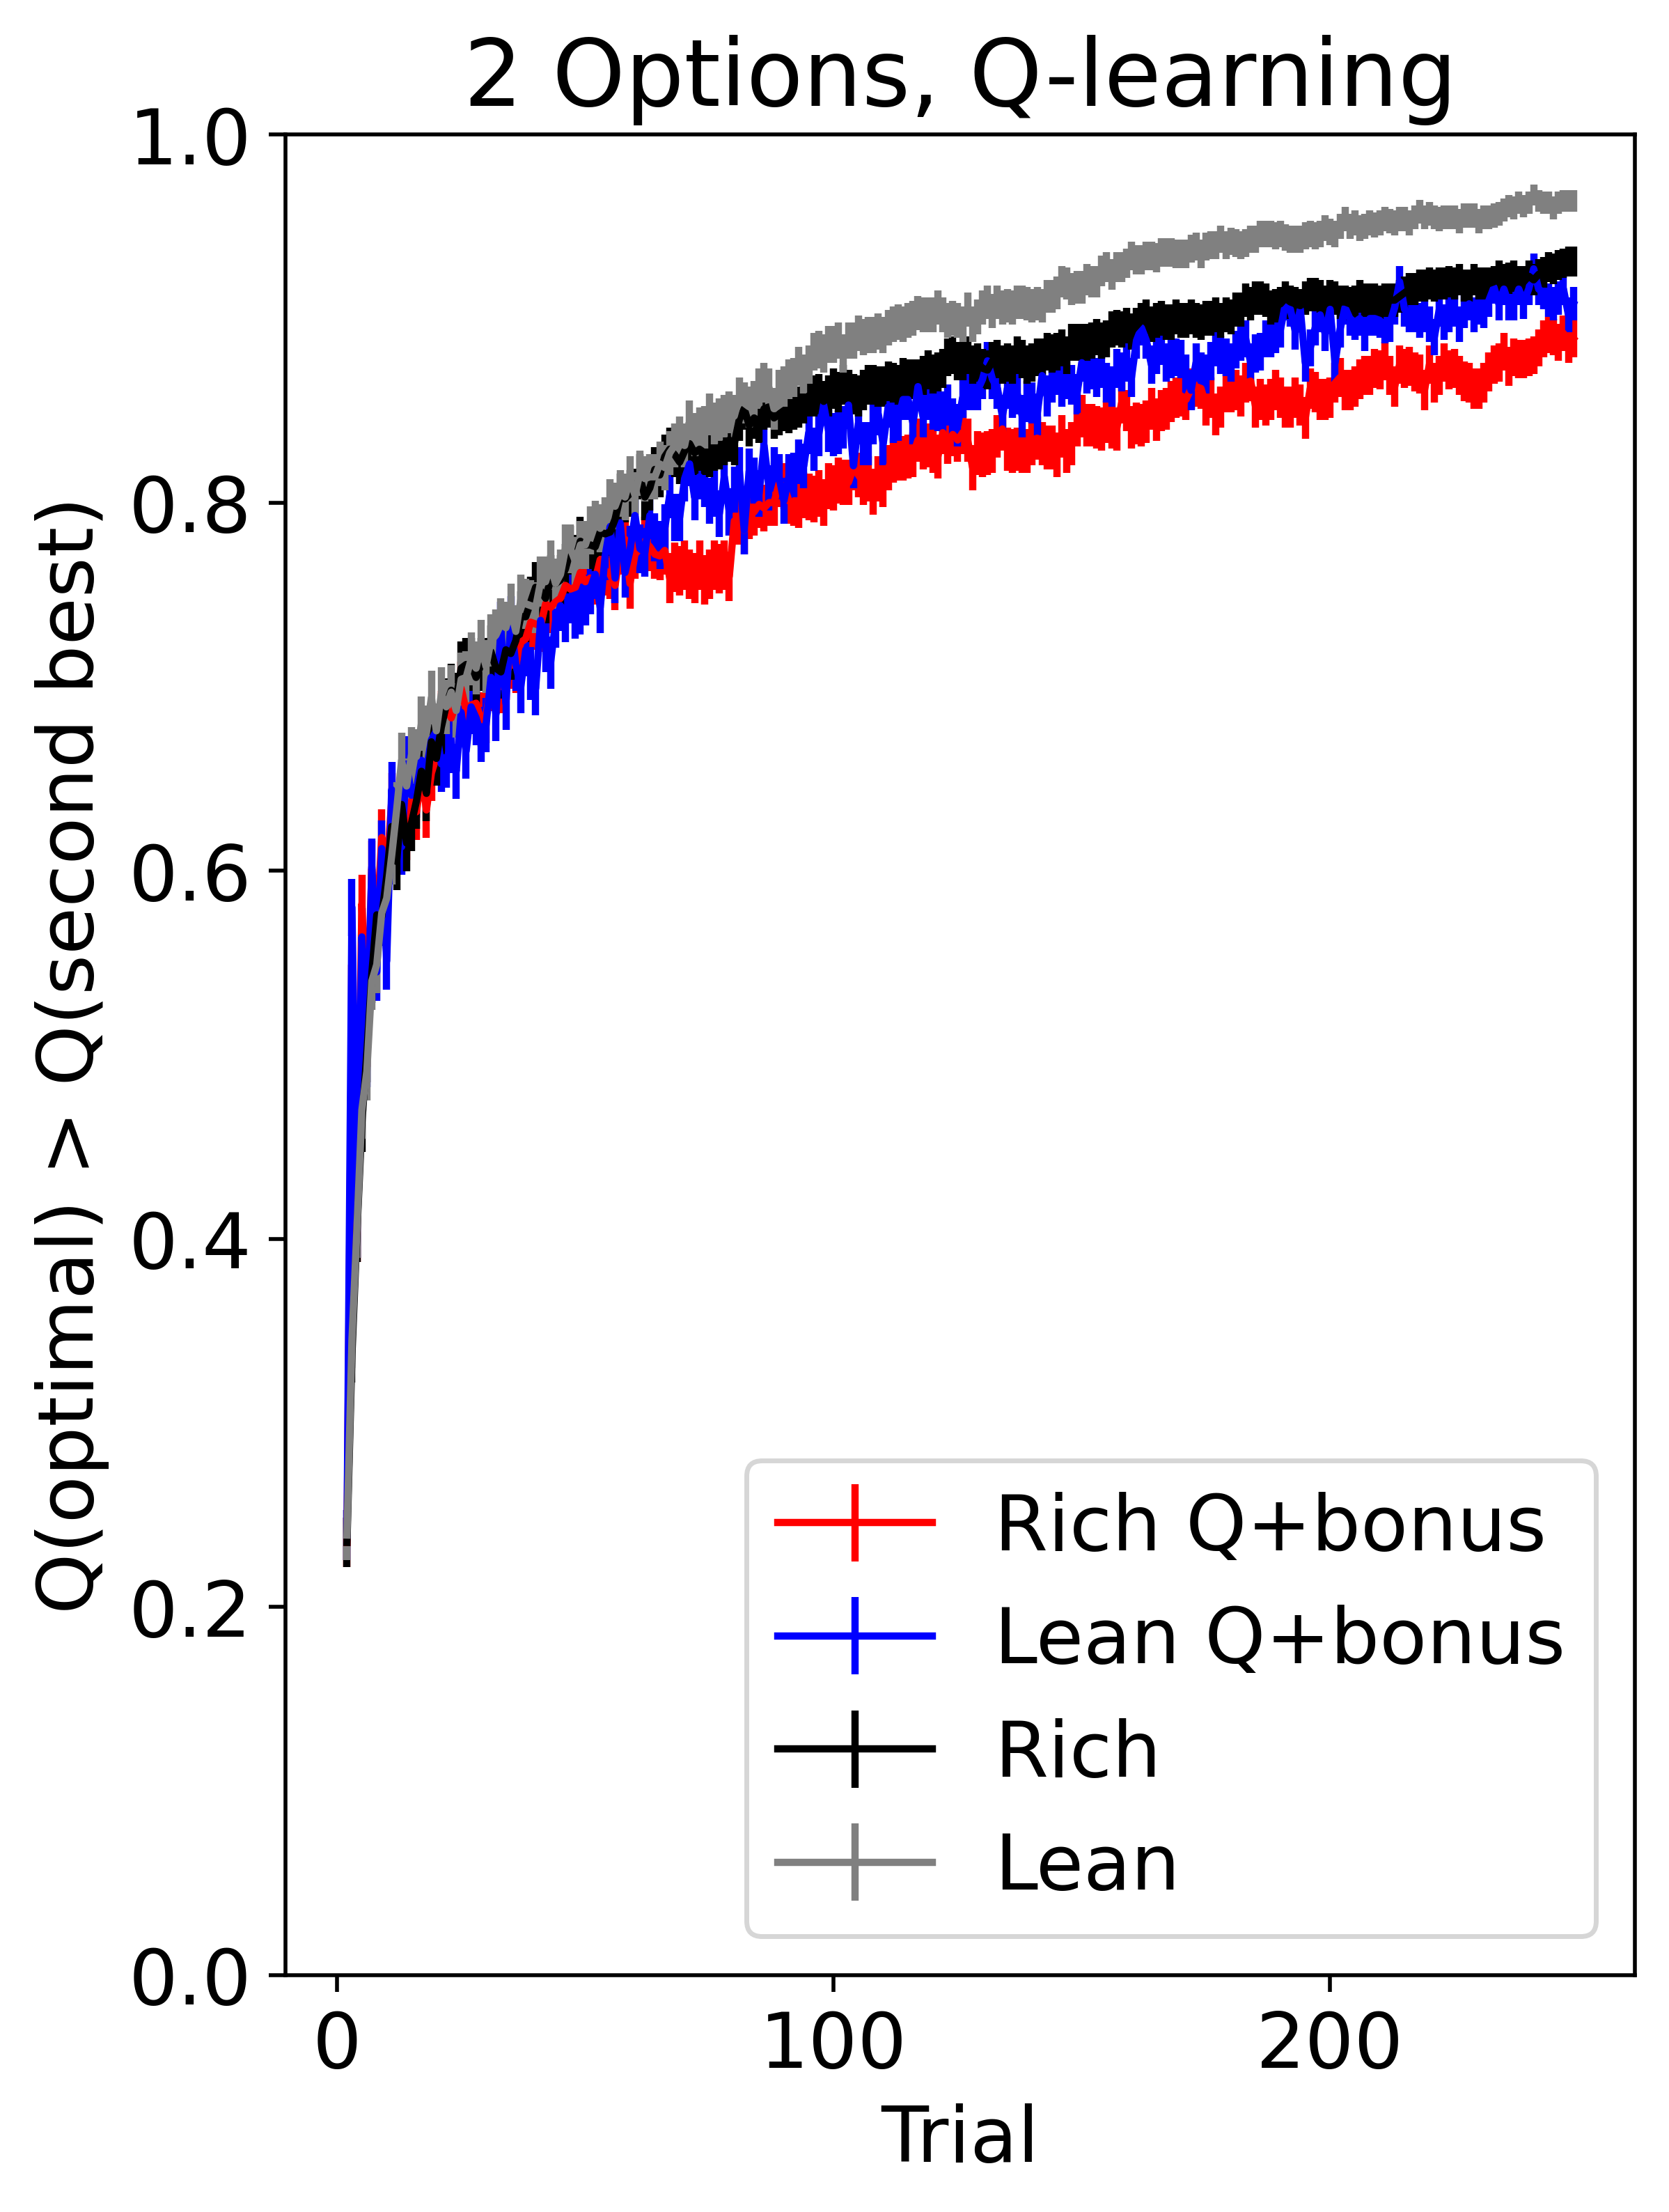

In [17]:
# UCB plots 
r_convergence = np.zeros([n_states,ntrials+1])
l_convergence = np.zeros([n_states,ntrials+1])

r_convergence_second = np.zeros([n_states,ntrials+1])
l_convergence_second = np.zeros([n_states,ntrials+1])

r_SM = np.zeros([n_states,ntrials+1])
l_SM = np.zeros([n_states,ntrials+1])

r_ag = np.zeros([n_states,ntrials+1])
l_ag = np.zeros([n_states,ntrials+1])

r_order_Acts = np.zeros([n_states,ntrials+1])
l_order_Acts = np.zeros([n_states,ntrials+1])

r_order_Qs = np.zeros([n_states,ntrials+1])
l_order_Qs = np.zeros([n_states,ntrials+1])
for i in np.arange(n_states):
     # difference from ground truth for optimal action
    r_state = R_UCB[i]
    r_err = r_state.Q[:,0] - .8    
    r_convergence[i,:] = r_err

    l_state = L_UCB[i]
    l_err = l_state.Q[:,0] - .3
    l_convergence[i,:] = l_err

    # second best option
    r_second_best = second_best_q(r_state)
    r_second_best_act = second_best_Act(r_state)
    r_err = np.array([r_state.Q[idx,second] for idx,second in enumerate(r_second_best)]) - .7
    r_convergence_second[i,:] = r_err

    l_second_best = second_best_q(l_state)
    l_second_best_act = second_best_Act(l_state)
    l_err = np.array([l_state.Q[idx,second] for idx,second in enumerate(l_second_best)]) - .2
    l_convergence_second[i,:] = l_err

    # action gap
    beta = r_state.beta # same for both env
    r_SM[i,:] = np.array([softmax(beta*r_state.Acts[idx,0],beta*r_state.Acts[idx,second]) for idx,second in enumerate(r_second_best)]) 
    l_SM[i,:] = np.array([softmax(beta*l_state.Acts[idx,0],beta*l_state.Acts[idx,second]) for idx,second in enumerate(l_second_best)]) 
    
    r_ag[i,:] = np.array([(r_state.Acts[idx,0] - r_state.Acts[idx,second]) for idx,second in enumerate(r_second_best)]) 
    l_ag[i,:] = np.array([(l_state.Acts[idx,0] - l_state.Acts[idx,second]) for idx,second in enumerate(l_second_best)]) 

    r_order_Acts[i,:] = np.array([int(r_state.Acts[idx,0] > r_state.Acts[idx,second]) for idx,second in enumerate(r_second_best_act)]) 
    l_order_Acts[i,:] = np.array([int(l_state.Acts[idx,0] > l_state.Acts[idx,second]) for idx,second in enumerate(l_second_best_act)]) 

    r_order_Qs[i,:] = np.array([int(r_state.Q[idx,0] > r_state.Q[idx,second]) for idx,second in enumerate(r_second_best)]) 
    l_order_Qs[i,:] = np.array([int(l_state.Q[idx,0] > l_state.Q[idx,second]) for idx,second in enumerate(l_second_best)]) 
    

UCB_r_conv_mean = np.mean(r_convergence,axis=0)
UCB_r_conv_sem = stats.sem(r_convergence)
UCB_l_conv_mean = np.mean(l_convergence,axis=0)
UCB_l_conv_sem = stats.sem(l_convergence)

# second best
UCB_r_conv_sec_mean = np.mean(r_convergence_second,axis=0)
UCB_r_conv_sec_sem = stats.sem(r_convergence_second)
UCB_l_conv_sec_mean = np.mean(l_convergence_second,axis=0)
UCB_l_conv_sec_sem = stats.sem(l_convergence_second)


# plt the things
str_me = complexity
xaxis = np.arange(ntrials-str_me) + str_me
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, UCB convergence" %(complexity))
axs.set_ylabel("Q hat (Sample Mean) - Qtrue")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,UCB_r_conv_mean[str_me:ntrials],yerr=UCB_r_conv_sem[str_me:ntrials], c = "gold")
axs.errorbar(xaxis,UCB_l_conv_mean[str_me:ntrials],yerr=UCB_l_conv_sem[str_me:ntrials], c = "blue")
axs.errorbar(xaxis,UCB_r_conv_sec_mean[str_me:ntrials],yerr=UCB_r_conv_sec_sem[str_me:ntrials], c = "cornsilk", linestyle = "dashed")
axs.errorbar(xaxis,UCB_l_conv_sec_mean[str_me:ntrials],yerr=UCB_l_conv_sec_sem[str_me:ntrials], c = "lightsteelblue", linestyle = "dashed")
axs.legend(["Rich Opt","Lean Opt","Rich 2nd","Lean 2nd"])
axs.axhline(y=0)
axs.set_ylim([-0.3,0.3])


# # true action gap 
# UCB_r_ag_mean = np.mean(r_ag,axis=0)
# UCB_r_ag_sem = stats.sem(r_ag)
# UCB_l_ag_mean = np.mean(l_ag,axis=0)
# UCB_l_ag_sem = stats.sem(l_ag)


# fig, axs = plt.subplots(figsize=(7, 5))
# axs.set_title("%d Options, UCB" %(complexity))
# axs.set_ylabel("Q hat(optimal) - Q hat(second best)")
# axs.set_xlabel("Trial")
# axs.errorbar(xaxis,UCB_r_ag_mean[str_me:ntrials],yerr=UCB_r_ag_sem[str_me:ntrials], c = "gold")
# axs.errorbar(xaxis,UCB_l_ag_mean[str_me:ntrials],yerr=UCB_l_ag_sem[str_me:ntrials], c = "blue")
# # axs.axhline(y=0)


# # SM action gap 
# UCB_r_SM_mean = np.mean(r_SM,axis=0)
# UCB_r_SM_sem = stats.sem(r_SM)
# UCB_l_SM_mean = np.mean(l_SM,axis=0)
# UCB_l_SM_sem = stats.sem(l_SM)


# fig, axs = plt.subplots(figsize=(7, 5))
# axs.set_title("%d Options, UCB" %(complexity))
# axs.set_ylabel("softmax( Q(optimal), Q(second best) )")
# axs.set_xlabel("Trial")
# axs.errorbar(xaxis,UCB_r_SM_mean[str_me:ntrials],yerr=UCB_r_SM_sem[str_me:ntrials], c = "gold")
# axs.errorbar(xaxis,UCB_l_SM_mean[str_me:ntrials],yerr=UCB_l_SM_sem[str_me:ntrials], c = "blue")
# axs.axhline(y=0.5)



# order
UCB_r_order_Acts_mean = np.mean(r_order_Acts,axis=0)
UCB_r_order_Acts_sem = stats.sem(r_order_Acts)
UCB_l_order_Acts_mean = np.mean(l_order_Acts,axis=0)
UCB_l_order_Acts_sem = stats.sem(l_order_Acts)

UCB_r_order_Qs_mean = np.mean(r_order_Qs,axis=0)
UCB_r_order_Qs_sem = stats.sem(r_order_Qs)
UCB_l_order_Qs_mean = np.mean(l_order_Qs,axis=0)
UCB_l_order_Qs_sem = stats.sem(l_order_Qs)


fig, axs = plt.subplots(figsize=(5, 7))
axs.set_title("%d Options, Q-learning" %(complexity))
axs.set_ylabel("Q(optimal) > Q(second best)")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,UCB_r_order_Acts_mean[str_me:ntrials],yerr=UCB_r_order_Acts_sem[str_me:ntrials], c = "red", label="Rich Q+bonus")
axs.errorbar(xaxis,UCB_l_order_Acts_mean[str_me:ntrials],yerr=UCB_l_order_Acts_sem[str_me:ntrials], c = "blue", label="Lean Q+bonus")
axs.errorbar(xaxis,UCB_r_order_Qs_mean[str_me:ntrials],yerr=UCB_r_order_Qs_sem[str_me:ntrials], c = "black", label="Rich")
axs.errorbar(xaxis,UCB_l_order_Qs_mean[str_me:ntrials],yerr=UCB_l_order_Qs_sem[str_me:ntrials], c = "grey", label="Lean")
axs.legend()
# axs.axhline(y=0.5)
axs.set_ylim([0.0,1.0])


### UCB - full

(0.0, 1.0)

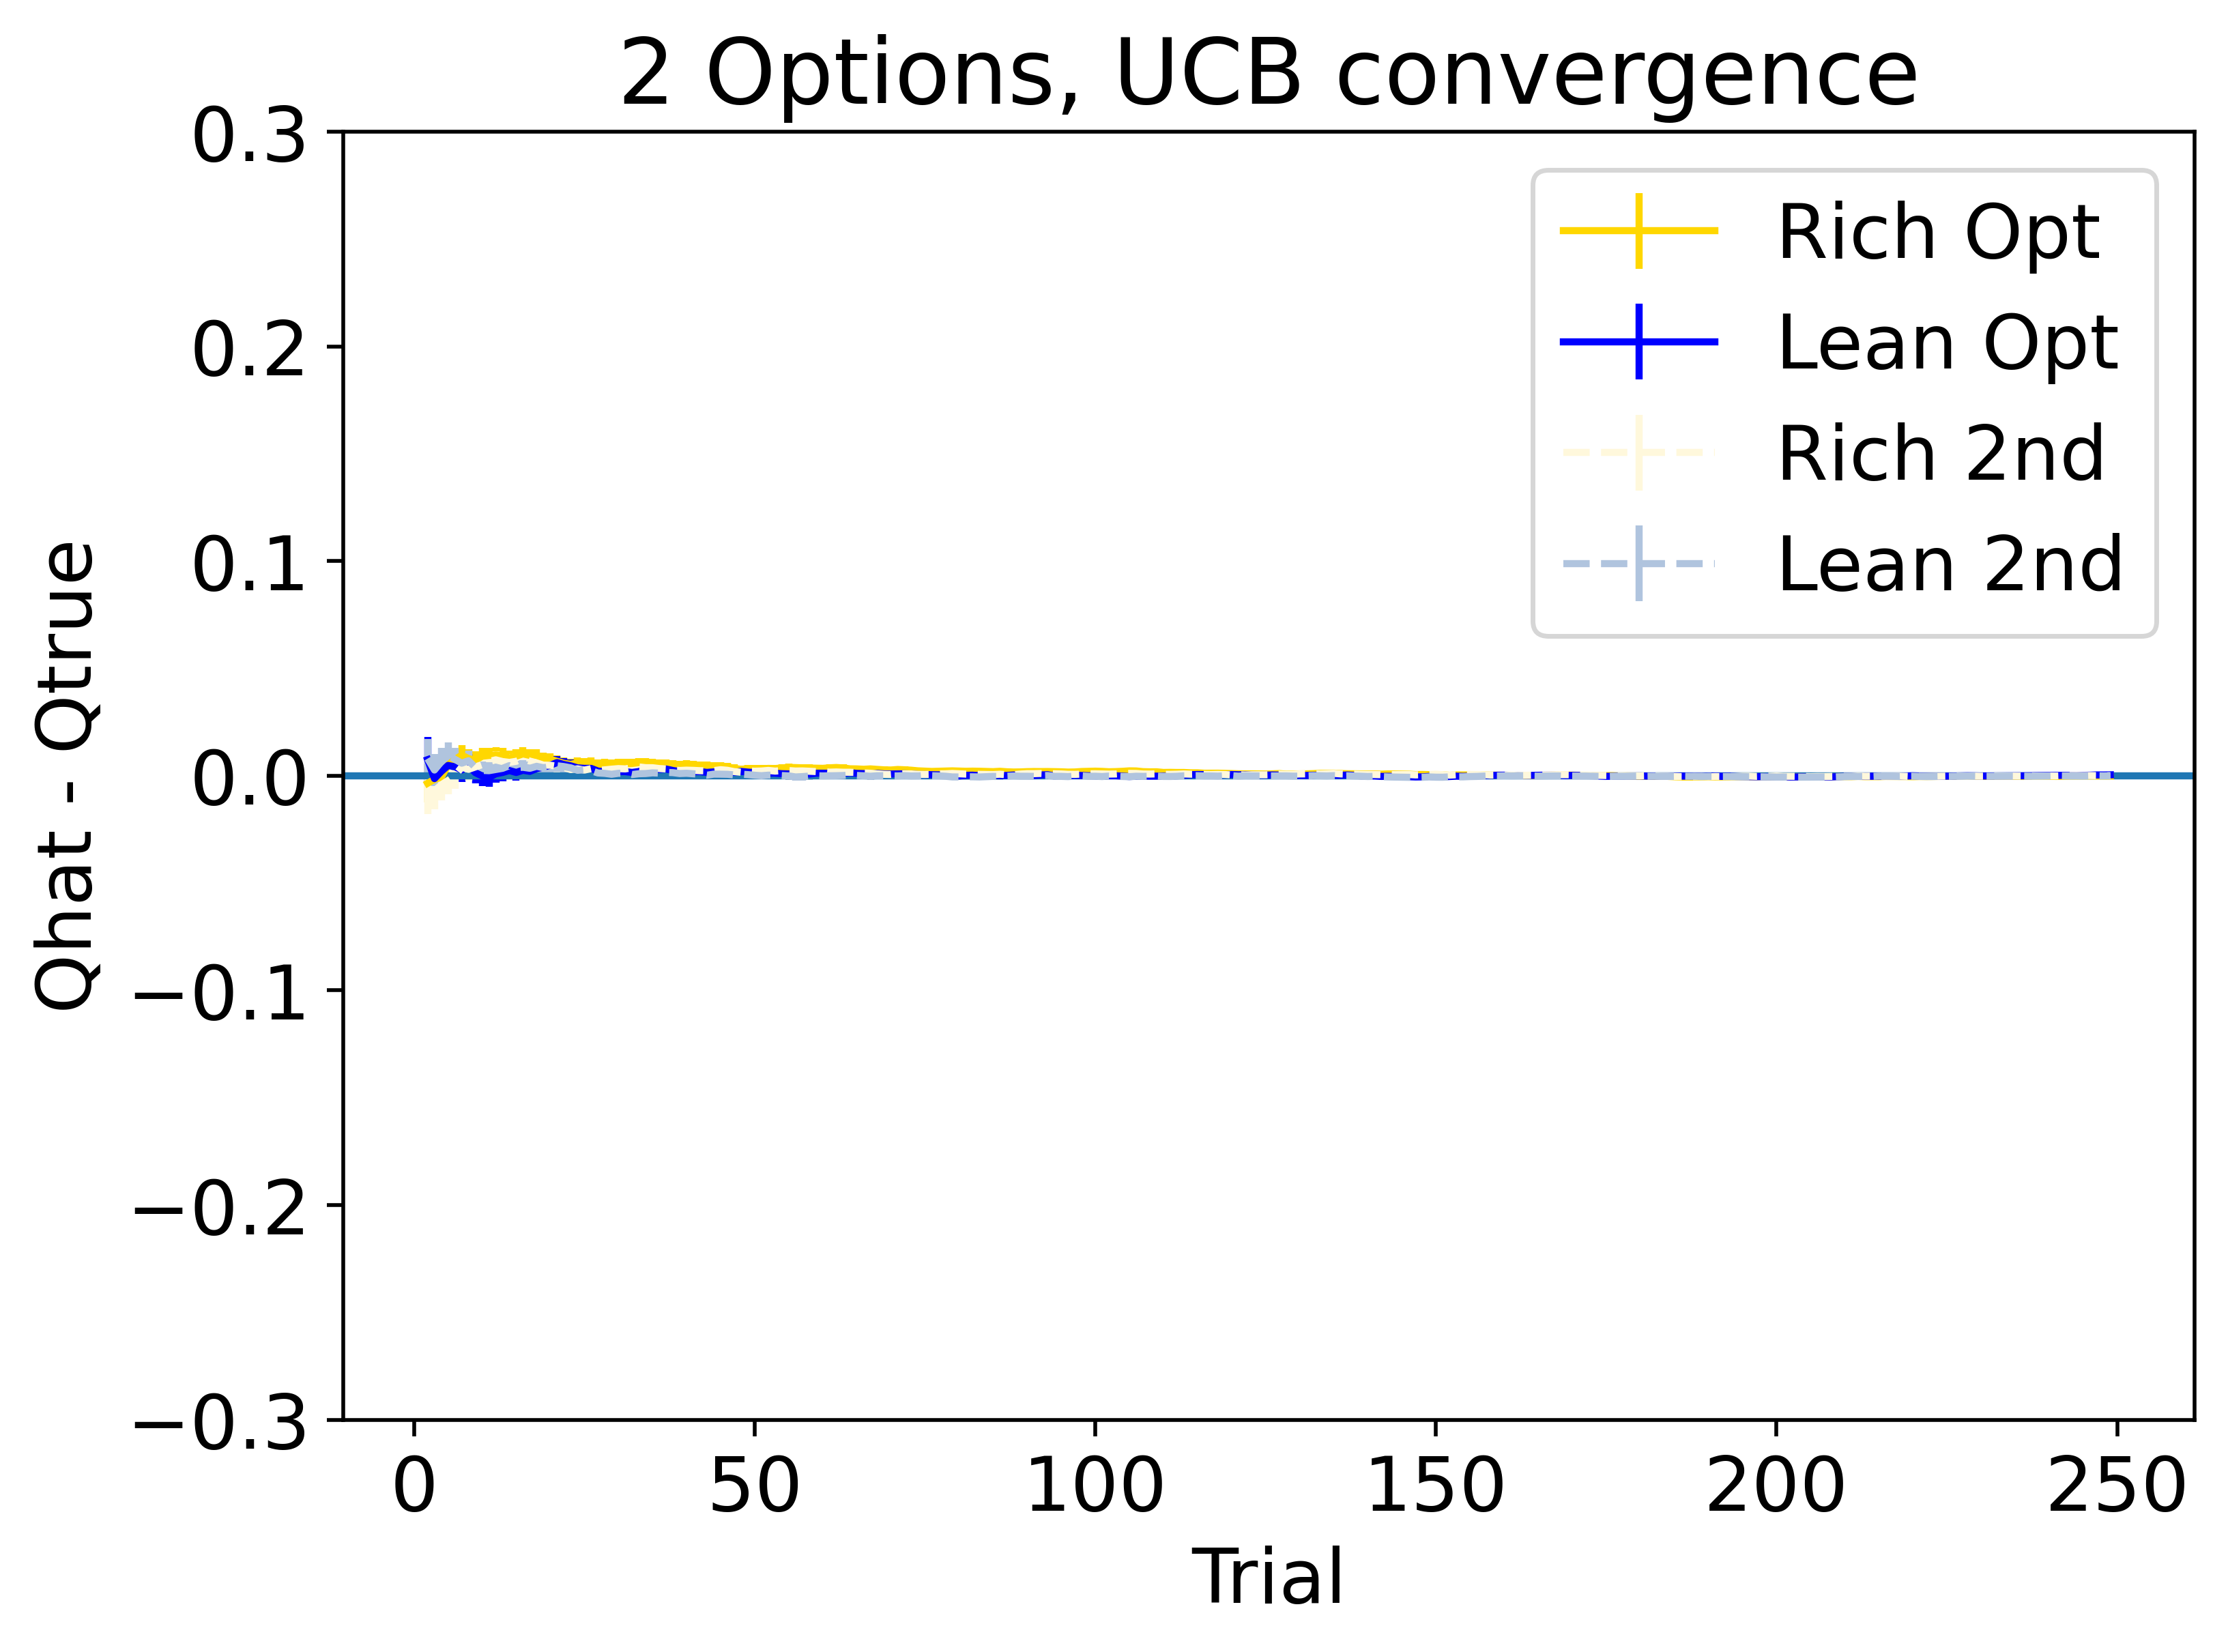

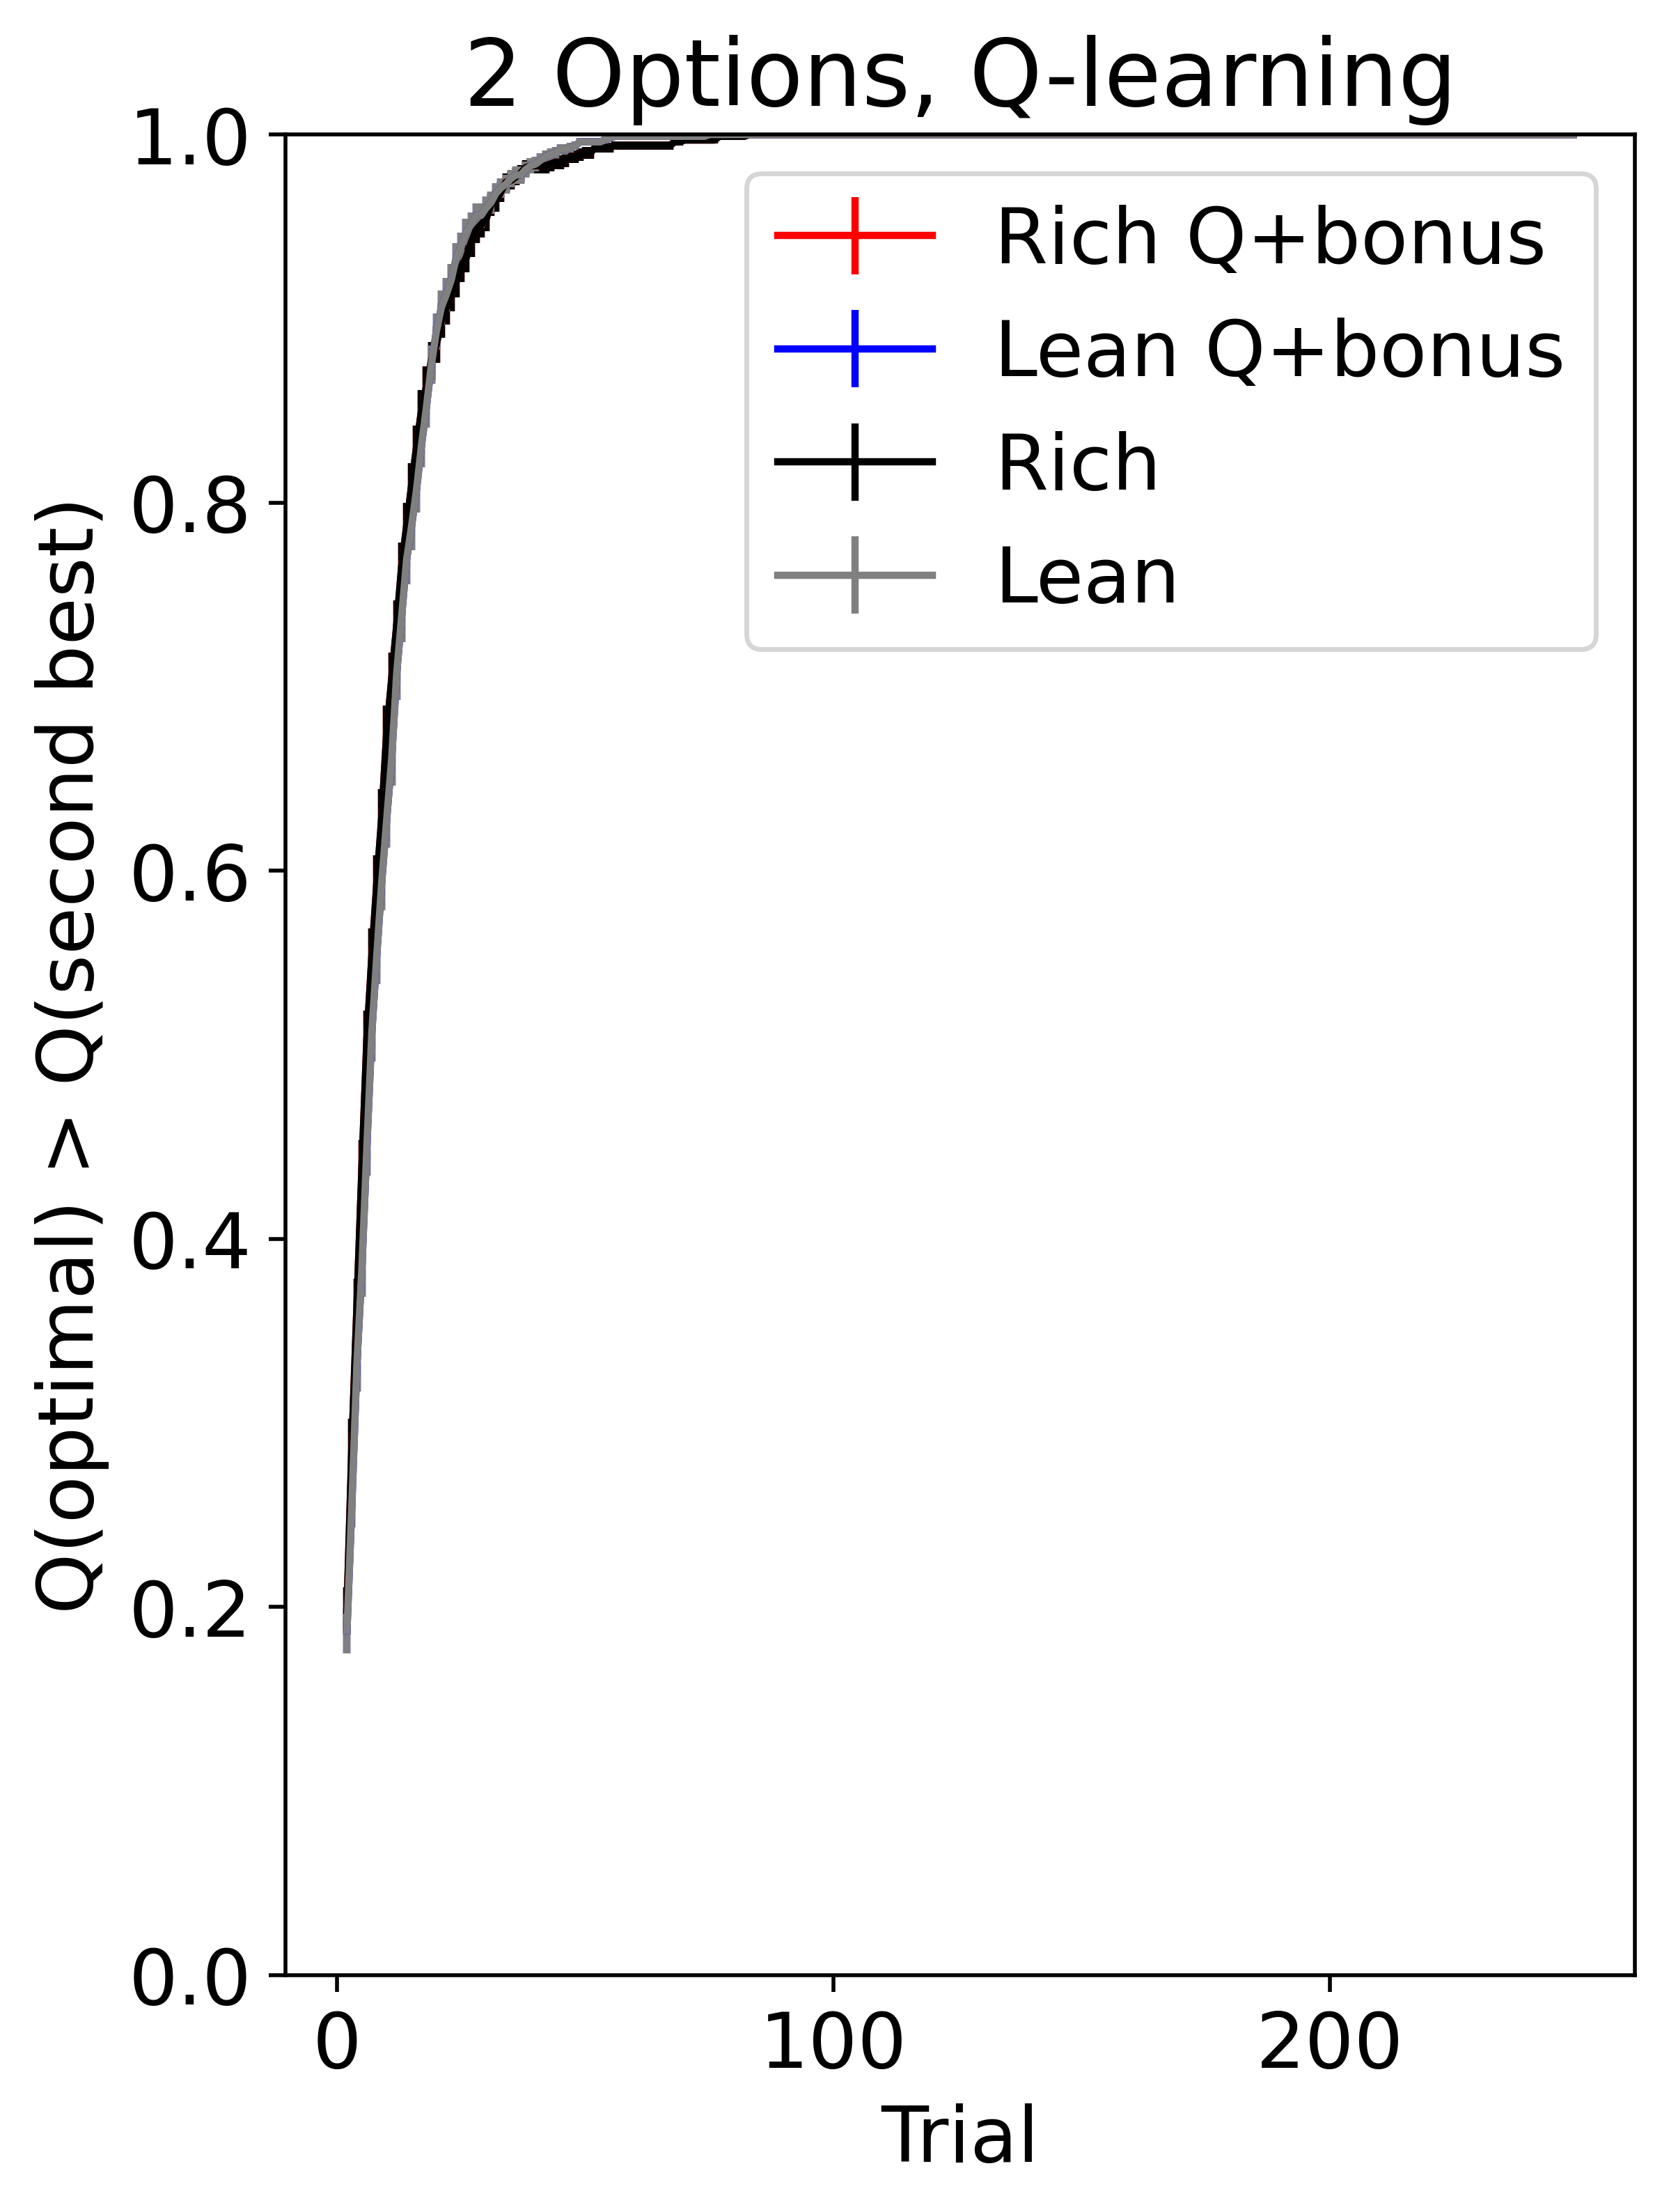

In [18]:
# Q-learning plots 
r_convergence = np.zeros([n_states,ntrials+1])
l_convergence = np.zeros([n_states,ntrials+1])

r_convergence_second = np.zeros([n_states,ntrials+1])
l_convergence_second = np.zeros([n_states,ntrials+1])

r_SM = np.zeros([n_states,ntrials+1])
l_SM = np.zeros([n_states,ntrials+1])

r_ag = np.zeros([n_states,ntrials+1])
l_ag = np.zeros([n_states,ntrials+1])

r_order_Acts = np.zeros([n_states,ntrials+1])
l_order_Acts = np.zeros([n_states,ntrials+1])

r_order_Qs = np.zeros([n_states,ntrials+1])
l_order_Qs = np.zeros([n_states,ntrials+1])
for i in np.arange(n_states):
     # difference from ground truth for optimal action
    r_state = R_UCB_Full_best[i]
    r_err = r_state.Q[:,0] - .8    
    r_convergence[i,:] = r_err

    l_state = L_UCB_Full_best[i]
    l_err = l_state.Q[:,0] - .3
    l_convergence[i,:] = l_err

    # second best option
    r_second_best = R_UCB_Full_second[i]
    r_err = r_second_best.Q[:,0] - .7
    r_convergence_second[i,:] = r_err

    l_second_best = L_UCB_Full_second[i]
    l_err = l_second_best.Q[:,0] - .2
    l_convergence_second[i,:] = l_err

    # action gap
    beta = r_state.beta # same for both env
    r_SM[i,:] = np.array([softmax(beta*r_state.Acts[idx,0],beta*r_second_best.Acts[idx,0]) for idx in range(ntrials+1)]) 
    l_SM[i,:] = np.array([softmax(beta*l_state.Acts[idx,0],beta*l_second_best.Acts[idx,0]) for idx in range(ntrials+1)]) 
    
    r_ag[i,:] = np.array([(r_state.Acts[idx,0] - r_second_best.Acts[idx,0]) for idx in range(ntrials+1)]) 
    l_ag[i,:] = np.array([(l_state.Acts[idx,0] - l_second_best.Acts[idx,0]) for idx in range(ntrials+1)]) 
    
    r_order_Acts[i,:] = np.array([int(r_state.Acts[idx,0] > r_second_best.Acts[idx,0]) for idx in range(ntrials+1)]) 
    l_order_Acts[i,:] = np.array([int(l_state.Acts[idx,0] > l_second_best.Acts[idx,0]) for idx in range(ntrials+1)]) 

    r_order_Qs[i,:] = np.array([int(r_state.Q[idx,0] > r_second_best.Q[idx,0]) for idx in range(ntrials+1)]) 
    l_order_Qs[i,:] = np.array([int(l_state.Q[idx,0] > l_second_best.Q[idx,0]) for idx in range(ntrials+1)]) 

    
    

UCB_FULL_r_conv_mean = np.mean(r_convergence,axis=0)
UCB_FULL_r_conv_sem = stats.sem(r_convergence)
UCB_FULL_l_conv_mean = np.mean(l_convergence,axis=0)
UCB_FULL_l_conv_sem = stats.sem(l_convergence)

# second best
UCB_FULL_r_conv_sec_mean = np.mean(r_convergence_second,axis=0)
UCB_FULL_r_conv_sec_sem = stats.sem(r_convergence_second)
UCB_FULL_l_conv_sec_mean = np.mean(l_convergence_second,axis=0)
UCB_FULL_l_conv_sec_sem = stats.sem(l_convergence_second)


# plt the things
str_me = complexity
xaxis = np.arange(ntrials-str_me) + str_me
fig, axs = plt.subplots(figsize=(7, 5))
axs.set_title("%d Options, UCB convergence" %(complexity))
axs.set_ylabel("Qhat - Qtrue")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,UCB_FULL_r_conv_mean[str_me:ntrials],yerr=UCB_FULL_r_conv_sem[str_me:ntrials], c = "gold")
axs.errorbar(xaxis,UCB_FULL_l_conv_mean[str_me:ntrials],yerr=UCB_FULL_l_conv_sem[str_me:ntrials], c = "blue")
axs.errorbar(xaxis,UCB_FULL_r_conv_sec_mean[str_me:ntrials],yerr=UCB_FULL_r_conv_sec_sem[str_me:ntrials], c = "cornsilk", linestyle = "dashed")
axs.errorbar(xaxis,UCB_FULL_l_conv_sec_mean[str_me:ntrials],yerr=UCB_FULL_l_conv_sec_sem[str_me:ntrials], c = "lightsteelblue", linestyle = "dashed")
axs.legend(["Rich Opt","Lean Opt","Rich 2nd","Lean 2nd"])
axs.axhline(y=0)
axs.set_ylim([-0.3,0.3])


# # true action gap 
# UCB_FULL_r_ag_mean = np.mean(r_ag,axis=0)
# UCB_FULL_r_ag_sem = stats.sem(r_ag)
# UCB_FULL_l_ag_mean = np.mean(l_ag,axis=0)
# UCB_FULL_l_ag_sem = stats.sem(l_ag)


# fig, axs = plt.subplots(figsize=(7, 5))
# axs.set_title("%d Options, UCB" %(complexity))
# axs.set_ylabel("Q hat(optimal) - Q hat(second best)")
# axs.set_xlabel("Trial")
# axs.errorbar(xaxis,UCB_FULL_r_ag_mean[str_me:ntrials],yerr=UCB_FULL_r_ag_sem[str_me:ntrials], c = "gold")
# axs.errorbar(xaxis,UCB_FULL_l_ag_mean[str_me:ntrials],yerr=UCB_FULL_l_ag_sem[str_me:ntrials], c = "blue")
# # axs.axhline(y=0)


# # SM action gap 
# UCB_FULL_r_SM_mean = np.mean(r_SM,axis=0)
# UCB_FULL_r_SM_sem = stats.sem(r_SM)
# UCB_FULL_l_SM_mean = np.mean(l_SM,axis=0)
# UCB_FULL_l_SM_sem = stats.sem(l_SM)


# fig, axs = plt.subplots(figsize=(7, 5))
# axs.set_title("%d Options, UCB" %(complexity))
# axs.set_ylabel("softmax( Q(optimal), Q(second best) )")
# axs.set_xlabel("Trial")
# axs.errorbar(xaxis,UCB_FULL_r_SM_mean[2:ntrials],yerr=UCB_FULL_r_SM_sem[2:ntrials], c = "gold")
# axs.errorbar(xaxis,UCB_FULL_l_SM_mean[2:ntrials],yerr=UCB_FULL_l_SM_sem[2:ntrials], c = "blue")
# axs.axhline(y=0.5)



# order
UCB_FULL_r_order_Acts_mean = np.mean(r_order_Acts,axis=0)
UCB_FULL_r_order_Acts_sem = stats.sem(r_order_Acts)
UCB_FULL_l_order_Acts_mean = np.mean(l_order_Acts,axis=0)
UCB_FULL_l_order_Acts_sem = stats.sem(l_order_Acts)

UCB_FULL_r_order_Qs_mean = np.mean(r_order_Qs,axis=0)
UCB_FULL_r_order_Qs_sem = stats.sem(r_order_Qs)
UCB_FULL_l_order_Qs_mean = np.mean(l_order_Qs,axis=0)
UCB_FULL_l_order_Qs_sem = stats.sem(l_order_Qs)


fig, axs = plt.subplots(figsize=(5, 7))
axs.set_title("%d Options, Q-learning" %(complexity))
axs.set_ylabel("Q(optimal) > Q(second best)")
axs.set_xlabel("Trial")
axs.errorbar(xaxis,UCB_FULL_r_order_Acts_mean[str_me:ntrials],yerr=UCB_FULL_r_order_Acts_sem[str_me:ntrials], c = "red", label="Rich Q+bonus")
axs.errorbar(xaxis,UCB_FULL_l_order_Acts_mean[str_me:ntrials],yerr=UCB_FULL_l_order_Acts_sem[str_me:ntrials], c = "blue", label="Lean Q+bonus")
axs.errorbar(xaxis,UCB_FULL_r_order_Qs_mean[str_me:ntrials],yerr=UCB_FULL_r_order_Qs_sem[str_me:ntrials], c = "black", label="Rich")
axs.errorbar(xaxis,UCB_FULL_l_order_Qs_mean[str_me:ntrials],yerr=UCB_FULL_l_order_Qs_sem[str_me:ntrials], c = "grey", label="Lean")
axs.legend()
# axs.axhline(y=0.5)
axs.set_ylim([0.0,1.0])


## Reformat figures

(0.0, 1.01)

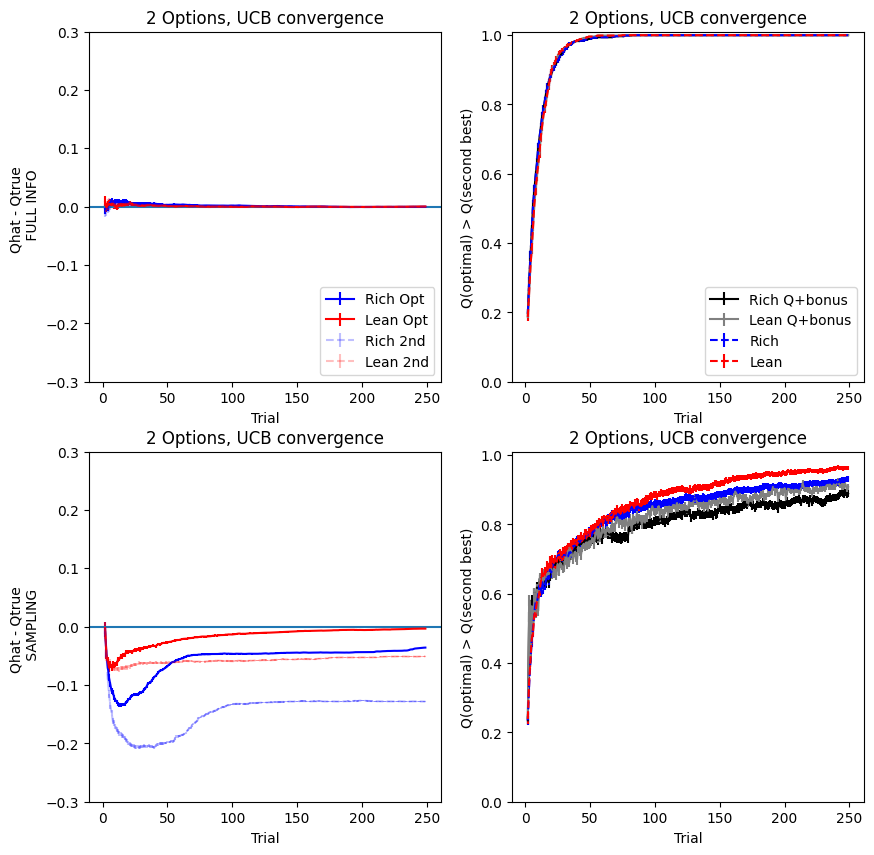

In [19]:
plt.rcParams.update(plt.rcParamsDefault)

fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(2,2)

# full information
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# stochastic choice information
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# full
ax1.set_title("%d Options, UCB convergence" %(complexity))
ax1.set_ylabel("Qhat - Qtrue \n FULL INFO")
ax1.set_xlabel("Trial")
str_me = complexity
xaxis = np.arange(ntrials-str_me) + str_me
ax1.errorbar(xaxis,UCB_FULL_r_conv_mean[str_me:ntrials],yerr=UCB_FULL_r_conv_sem[str_me:ntrials], c = (0,0,1))
ax1.errorbar(xaxis,UCB_FULL_l_conv_mean[str_me:ntrials],yerr=UCB_FULL_l_conv_sem[str_me:ntrials], c = (1,0,0))
ax1.errorbar(xaxis,UCB_FULL_r_conv_sec_mean[str_me:ntrials],yerr=UCB_FULL_r_conv_sec_sem[str_me:ntrials], c = (0,0,1, 0.25), linestyle = "dashed")
ax1.errorbar(xaxis,UCB_FULL_l_conv_sec_mean[str_me:ntrials],yerr=UCB_FULL_l_conv_sec_sem[str_me:ntrials], c = (1,0,0,0.25), linestyle = "dashed")
ax1.legend(["Rich Opt","Lean Opt","Rich 2nd","Lean 2nd"],loc="lower right")
ax1.axhline(y=0)
ax1.set_ylim([-0.3,0.3])

ax2.set_title("%d Options, UCB convergence" %(complexity))
ax2.set_ylabel("Q(optimal) > Q(second best)")
ax2.set_xlabel("Trial")
ax2.errorbar(xaxis,UCB_FULL_r_order_Acts_mean[str_me:ntrials],yerr=UCB_FULL_r_order_Acts_sem[str_me:ntrials], c = "black", label="Rich Q+bonus")
ax2.errorbar(xaxis,UCB_FULL_l_order_Acts_mean[str_me:ntrials],yerr=UCB_FULL_l_order_Acts_sem[str_me:ntrials], c = "grey", label="Lean Q+bonus")
ax2.errorbar(xaxis,UCB_FULL_r_order_Qs_mean[str_me:ntrials],yerr=UCB_FULL_r_order_Qs_sem[str_me:ntrials], c = (0,0,1), label="Rich", linestyle = "dashed")
ax2.errorbar(xaxis,UCB_FULL_l_order_Qs_mean[str_me:ntrials],yerr=UCB_FULL_l_order_Qs_sem[str_me:ntrials], c = (1,0,0), label="Lean", linestyle = "dashed")
ax2.legend(loc="lower right")
# axs.axhline(y=0.5)
ax2.set_ylim([0.0,1.01])



# stochastic
ax3.set_title("%d Options, UCB convergence" %(complexity))
ax3.set_ylabel("Qhat - Qtrue \n SAMPLING")
ax3.set_xlabel("Trial")
ax3.errorbar(xaxis,UCB_r_conv_mean[str_me:ntrials],yerr=UCB_FULL_r_conv_sem[str_me:ntrials], c = (0,0,1))
ax3.errorbar(xaxis,UCB_l_conv_mean[str_me:ntrials],yerr=UCB_FULL_l_conv_sem[str_me:ntrials], c = (1,0,0))
ax3.errorbar(xaxis,UCB_r_conv_sec_mean[str_me:ntrials],yerr=UCB_FULL_r_conv_sec_sem[str_me:ntrials], c = (0,0,1, 0.25), linestyle = "dashed")
ax3.errorbar(xaxis,UCB_l_conv_sec_mean[str_me:ntrials],yerr=UCB_FULL_l_conv_sec_sem[str_me:ntrials], c = (1,0,0,0.25), linestyle = "dashed")
# ax3.legend(["Rich Opt","Lean Opt","Rich 2nd","Lean 2nd"])
ax3.axhline(y=0)
ax3.set_ylim([-0.3,0.3])

ax4.set_title("%d Options, UCB convergence" %(complexity))
ax4.set_ylabel("Q(optimal) > Q(second best)")
ax4.set_xlabel("Trial")
ax4.errorbar(xaxis,UCB_r_order_Acts_mean[str_me:ntrials],yerr=UCB_r_order_Acts_sem[str_me:ntrials], c = "black", label="Rich Q+bonus")
ax4.errorbar(xaxis,UCB_l_order_Acts_mean[str_me:ntrials],yerr=UCB_l_order_Acts_sem[str_me:ntrials], c = "grey", label="Lean Q+bonus")
ax4.errorbar(xaxis,UCB_r_order_Qs_mean[str_me:ntrials],yerr=UCB_r_order_Qs_sem[str_me:ntrials], c = (0,0,1), label="Rich",linestyle = "dashed")
ax4.errorbar(xaxis,UCB_l_order_Qs_mean[str_me:ntrials],yerr=UCB_l_order_Qs_sem[str_me:ntrials], c = (1,0,0), label="Lean",linestyle = "dashed")
# ax4.legend()
# axs.axhline(y=0.5)
ax4.set_ylim([0.0,1.01])


# INCORRECT MODULATIONS

In [20]:
env = "30_10_%d" %(complexity)
rnd_seeds_OpAL = pickle.load(open("../random_seeds/OpAL/%s_rnd_seeds.pkle" %(env),"rb"))
L_states_OpAL_Star_flipped = learning.simulate(auc_orders[str_complexity]['SACrit_BayesAnneal_mod'][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad,
        variant="flip")
env = "80_10_%d" %(complexity)
rnd_seeds_OpAL = pickle.load(open("../random_seeds/OpAL/%s_rnd_seeds.pkle" %(env),"rb"))
R_states_OpAL_Star_flipped = learning.simulate(auc_orders[str_complexity]['SACrit_BayesAnneal_mod'][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad,
        variant="flip")


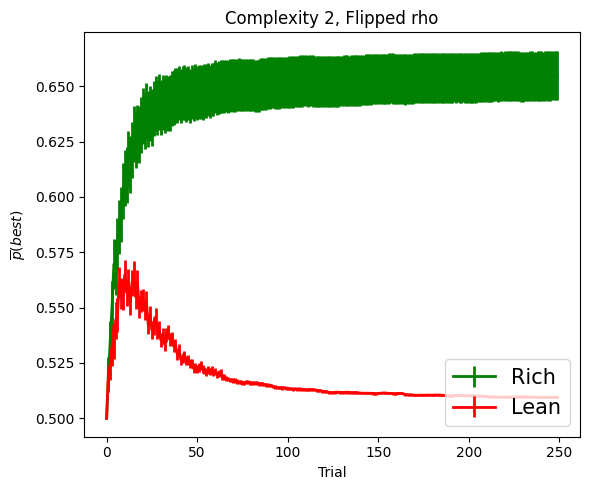

In [21]:
fig, axs = plt.subplots(figsize=(6, 5))
plot_dynamics.avg_sm(R_states_OpAL_Star_flipped,ntrials,n_states,0,axs,"green")
plot_dynamics.avg_sm(L_states_OpAL_Star_flipped,ntrials,n_states,0,axs,"red")
plt.legend(("Rich", "Lean"), fontsize = 15, markerscale = 50, loc = 'lower right')
plt.title("Complexity %d, Flipped rho" %(complexity))
plt.xlabel("Trial")
plt.ylabel("$\overline{p}(best)$")
#   plt.ylim([.5,.8])
plt.tight_layout()

# Explore/exploit - flipping dynamics in policy

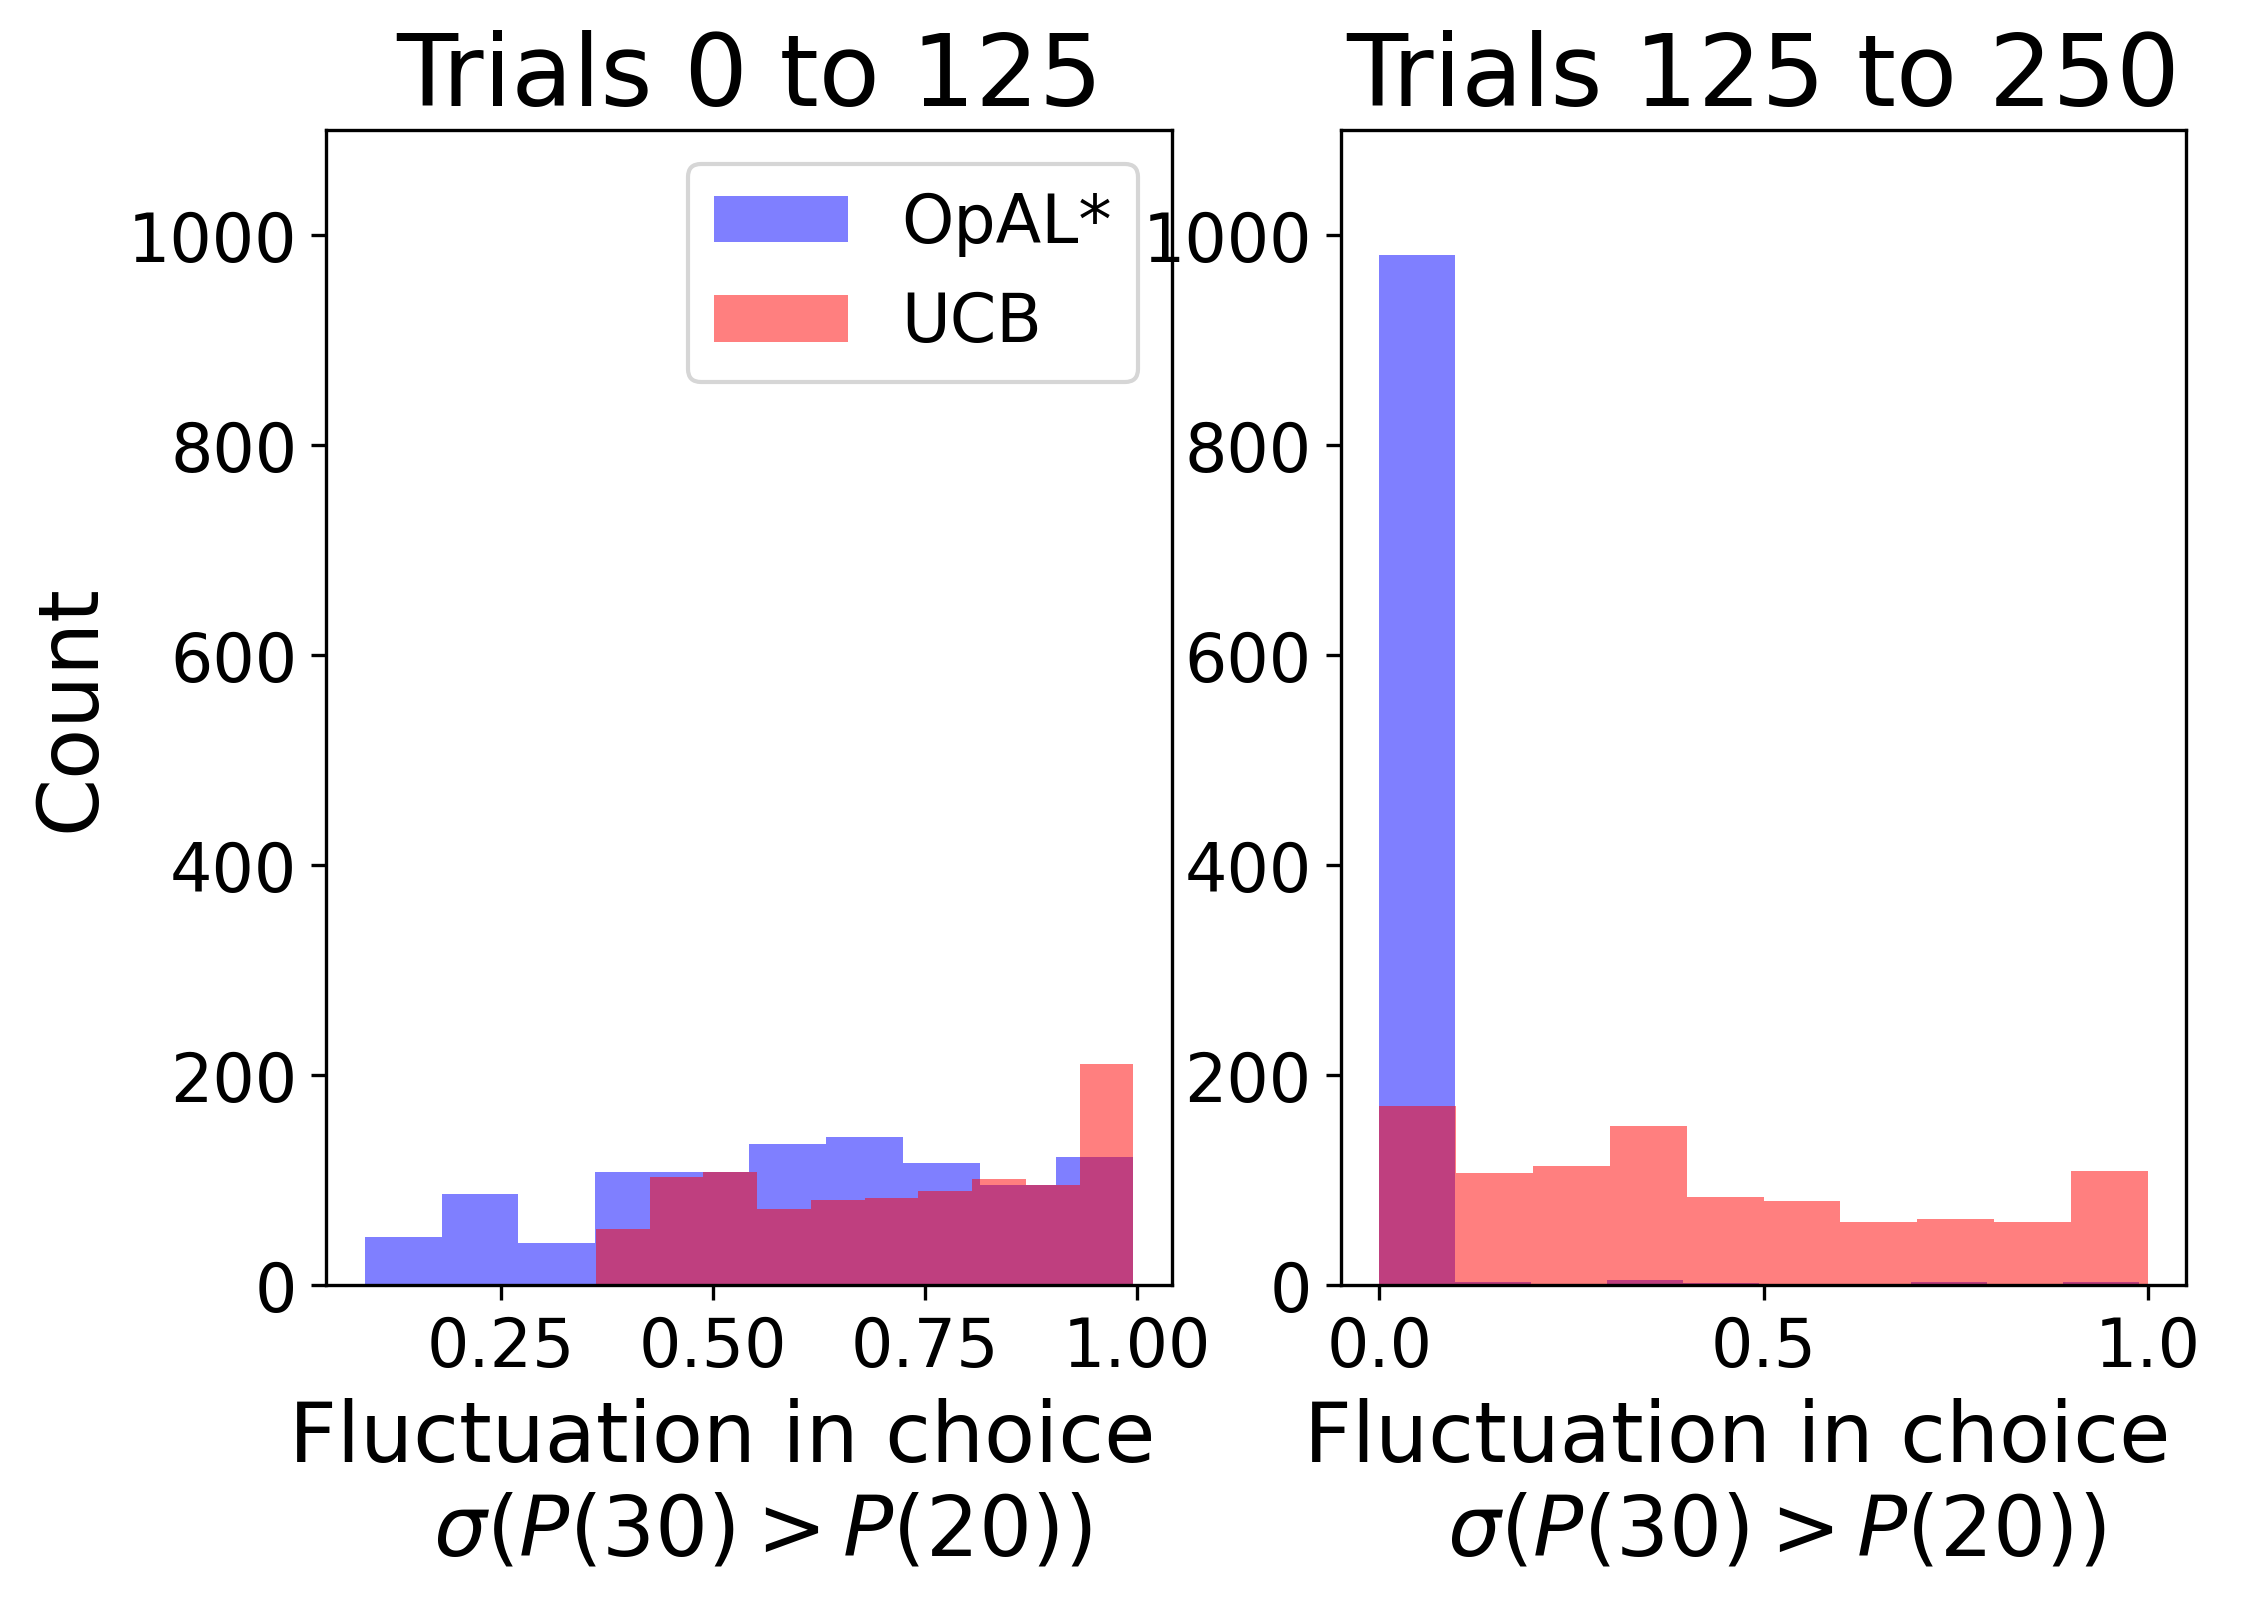

In [22]:
plt.rcParams.update({'font.size': 16})

# step size to plot
shift = 0
step = 125
index = 0
fromMe = 0 + shift
tilMe = step + shift

# opal* vs no hebb comparison
nplots = ntrials/step
fig_cmpOH, axs_cmpOH = plt.subplots(1,int(nplots),figsize=(int(4*nplots),5),dpi = 300)

while (fromMe < ntrials):

    # ACT VARIANCE
    # opal*
    L_actvar = [np.std(np.sign(L_states_OpAL_Star[i].SM[fromMe:tilMe,0] - L_states_OpAL_Star[i].SM[fromMe:tilMe,1]),axis=0) for i in range(n_states)]
    L_actvar_Q = [np.std(np.sign(L_Q[i].SM[fromMe:tilMe,0] - L_Q[i].SM[fromMe:tilMe,1]),axis=0) for i in range(n_states)]
    L_actvar_UCB = [np.std(np.sign(L_UCB[i].SM[fromMe:tilMe,0] - L_UCB[i].SM[fromMe:tilMe,1]),axis=0) for i in range(n_states)]
    L_actvar_NoHebb = [np.std(np.sign(L_states_OpAL_NoHebb[i].SM[fromMe:tilMe,0] - L_states_OpAL_NoHebb[i].SM[fromMe:tilMe,1]),axis=0) for i in range(n_states)]

    # plot the things
    
    # act comparisons
    axs_cmpOH[index].hist(L_actvar,fc=(0, 0, 1, 0.5))
    # axs_cmpOH[index].hist(L_actvar_Q,fc=(0, 1, 0., 0.5))
    axs_cmpOH[index].hist(L_actvar_UCB,fc=(1, 0, 0., 0.5))
    # axs_cmpOH[index].hist(L_actvar_NoHebb,fc=(.5, 0., 0.5, 0.5))
    if index == 0:
        axs_cmpOH[index].legend(["OpAL*","UCB"],fontsize=16)
    axs_cmpOH[index].set_title("Trials %d to %d" %(fromMe,tilMe),fontsize=24)
    axs_cmpOH[index].set_xlabel("Fluctuation in choice  \n $\sigma(P(30)>P(20))$",fontsize=20)
    if index == 0:
        axs_cmpOH[index].set_ylabel("Count",fontsize=20)
    axs_cmpOH[index].set_ylim(0,1100)


    shift = shift + step
    index = index + 1
    fromMe = 0 + shift
    tilMe = step + shift



# Run matched random seeds to make sure examples are equal

In [23]:
importlib.reload(opal)
importlib.reload(learning)
importlib.reload(rl)
importlib.reload(learn)

<module 'learn' from '/Users/ajaskir/Desktop/FYP/opal/notebooks/../standard_rl/learn.py'>

In [24]:
# generate forced actions and rewards
n_states_forced = 30
ntrials = 1000
complexity = 6

forced_actions = np.random.randint(0,complexity,size=[n_states_forced,ntrials+1])
forced_rewards = np.zeros(shape=[n_states_forced,ntrials+1])
for i in np.arange(n_states_forced):
        forced_rewards[i,:] = [np.random.binomial(size=1, n=1, p= .3)[0] if a == 0 else np.random.binomial(size=1, n=1, p= .2)[0] for a in forced_actions[i,:]]

        # sanity check
        # find_action = np.where(forced_actions[i,:] == 0)[0]
        # print(sum([forced_rewards[i,idx] for idx in find_action])/len(find_action))
        # find_action = np.where(forced_actions[i,:] == 1)[0]
        # print(sum([forced_rewards[i,idx] for idx in find_action])/len(find_action))

env = "30_10_%d" %(complexity)
L_states_OpAL_plus_FORCED = learning.simulate(auc_orders[str_complexity]['SACrit_BayesAnneal'][0],n_states_forced,ntrials,v0=v0,crit=crit,env=env,mod="constant",k=k,norm=norm,    
        mag=mag,anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad,\
        forced_actions=forced_actions, forced_rewards=forced_rewards)
L_states_OpAL_Star_FORCED = learning.simulate(auc_orders[str_complexity]['SACrit_BayesAnneal_mod'][0],n_states_forced,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad,\
        forced_actions=forced_actions, forced_rewards=forced_rewards)
L_states_OpAL_NoHebb_FORCED = learning.simulate(auc_orders[str_complexity]['NoHebb'][0],n_states_forced,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad, 
        hebb=False,\
        forced_actions=forced_actions, forced_rewards=forced_rewards)
L_UCB_FORCED = learn.simulate(np.array([0.,0.]),n_states_forced,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=auc_orders[str_complexity]['UCB'][0],forced_actions=forced_actions, forced_rewards=forced_rewards)
L_Q_FORCED = learn.simulate(auc_orders[str_complexity]['RL'][0],n_states_forced,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,forced_actions=forced_actions, forced_rewards=forced_rewards)

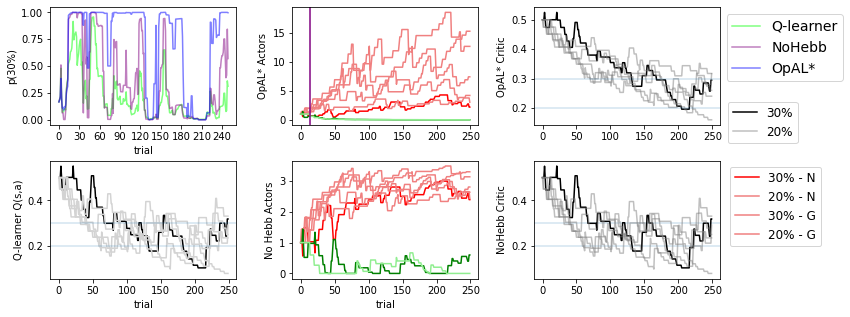

In [25]:
# compare all models in one

from matplotlib.ticker import MaxNLocator
plt.close('all') 
%matplotlib inline

shift = 0
step = 250
index = 0
fromMe = 0 + shift
tilMe = step + shift
# for i in np.arange(10):
#     print(L_nohebb_signs[i])
xaxis = np.arange(0,step)
sim_to_use = 0 # 

for i in np.arange(1):
    sim_to_use = 8

    fig = plt.figure(figsize = (6*2,5))
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    gs = fig.add_gridspec(2,3)
    ax1 = fig.add_subplot(gs[0, 0]) # :,0
    ax4 = fig.add_subplot(gs[1, 0]) 
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[0, 2])
    ax6 = fig.add_subplot(gs[1, 2])

    # plot behavior
    ax1.plot(xaxis,L_Q_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.0,1.,.0,0.5))    # L_Q, L_UCB, L_states_OpAL_NoHebb
    ax1.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.5,0,.5,0.5))    # L_Q, L_UCB, L_states_OpAL_NoHebb
    ax1.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.0,.0,1.0,0.5))
    # axs[0].legend(["OpAL*","Alt"])
    ax1.set_ylabel("p(30%)")
    ax1.set_xlabel("trial")
    ax1.legend(["Q-learner","NoHebb","OpAL*"],fontsize=14,bbox_to_anchor=(4.3, 1.0))
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))


    # plot avg N
    # plot_dynamics.avg_qs(L_states_OpAL_Star_FORCED,ntrials,n_states_forced,0,[ax4,ax4],1.0)
    # plot_dynamics.avg_qs(L_states_OpAL_Star_FORCED,ntrials,n_states_forced,1,[ax4,ax4],0.5)
    # ax4.set_xlabel("trial")
    # ax4.set_ylabel("OpAL* - average N")

    # plot N weights
    ax2.set_ylabel("OpAL* Actors")
    ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,0],color="red")
    for alt in np.arange(complexity-1):
        ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,alt + 1],color="lightcoral")
    ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QG[fromMe:tilMe,0],color="green")
    ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QG[fromMe:tilMe,1],color="lightgreen")
    DAonset = np.where(L_states_OpAL_Star_FORCED[sim_to_use].rho == 0)[0][-1] + 1 # add DA onset
    ax2.axvline(x= DAonset, color = "purple")
    # ax2.legend(["30\%","20\%"],fontsize=14,loc = "upper right")

    # convergence
    ax5.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].V[fromMe:tilMe,0],color = "black")
    ax5.set_ylabel("OpAL* Critic")
    for alt in np.arange(complexity-1):
        ax5.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].V[fromMe:tilMe,alt + 1],color = (0.5,0.5,0.5,0.5))
    ax5.legend(["30%","20%"], fontsize=12, bbox_to_anchor=(1.45, 0.25))
    ax5.axhline(y=.3, linewidth = .3)
    ax5.axhline(y=.2, linewidth = .3)

    # plot No Hebb values
    ax3.set_ylabel("No Hebb Actors")
    ax3.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].QN[fromMe:tilMe,0],color="red")
    for alt in np.arange(complexity-1):
        ax3.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].QN[fromMe:tilMe,alt+1],color="lightcoral")
    ax3.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].QG[fromMe:tilMe,0],color="green")
    ax3.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].QG[fromMe:tilMe,1],color="lightgreen")
    ax3.legend(["30% - N","20% - N","30% - G","20% - G"], fontsize=12,bbox_to_anchor=(2.875, 1.))
    ax3.set_xlabel("trial")

        # convergence
    ax6.axhline(y=.3, linewidth = .3)
    ax6.axhline(y=.2, linewidth = .3)
    ax6.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].V[fromMe:tilMe,0],color = "black")
    ax6.set_ylabel("NoHebb Critic")
    for alt in np.arange(complexity-1):
        ax6.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].V[fromMe:tilMe,alt + 1],color = (0.5,0.5,0.5,0.5))

    # plot Q values
    ax4.set_ylabel("Q-learner Q(s,a)")
    ax4.plot(xaxis,L_Q_FORCED[sim_to_use].Q[fromMe:tilMe,0],color="black")
    for alt in np.arange(complexity-1):
        ax4.plot(xaxis,L_Q_FORCED[sim_to_use].Q[fromMe:tilMe,alt + 1],color="lightgrey")
    ax4.axhline(y=.3, linewidth = .3)
    ax4.axhline(y=.2, linewidth = .3)
    # ax3.legend(["30\%","20\%"], fontsize=14, loc = "upper right")
    ax4.set_xlabel("trial")


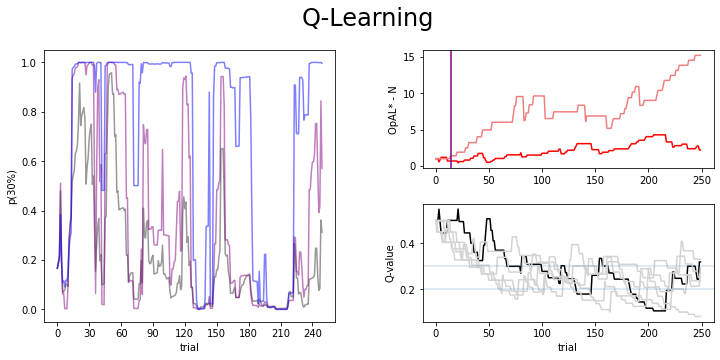

In [26]:
# compare all models in one

from matplotlib.ticker import MaxNLocator
plt.close('all') 
%matplotlib inline

shift = 0
step = 250
index = 0
fromMe = 0 + shift
tilMe = step + shift
# for i in np.arange(10):
#     print(L_nohebb_signs[i])
xaxis = np.arange(0,step)
sim_to_use = 0 # 

for i in np.arange(1):
    sim_to_use = 8

    fig = plt.figure(figsize = (6*2,5))
    plt.subplots_adjust(wspace=0.2,hspace=0.3)
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[:, 0]) # :,0
    # ax4 = fig.add_subplot(gs[, 0]) 
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    # plot behavior
    ax1.plot(xaxis,L_Q_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.2,.2,.2,0.5))    # L_Q, L_UCB, L_states_OpAL_NoHebb
    ax1.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.5,0,.5,0.5))    # L_Q, L_UCB, L_states_OpAL_NoHebb
    ax1.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.0,.0,1.0,0.5))
    # axs[0].legend(["OpAL*","Alt"])
    ax1.set_ylabel("p(30%)")
    ax1.set_xlabel("trial")
    # ax1.legend(["Q-learner","OpAL*"],fontsize=14,loc = "lower right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))


    # plot avg N
    # plot_dynamics.avg_qs(L_states_OpAL_Star_FORCED,ntrials,n_states_forced,0,[ax4,ax4],1.0)
    # plot_dynamics.avg_qs(L_states_OpAL_Star_FORCED,ntrials,n_states_forced,1,[ax4,ax4],0.5)
    # ax4.set_xlabel("trial")
    # ax4.set_ylabel("OpAL* - average N")

    # plot N weights
    ax2.set_ylabel("OpAL* - N")
    ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,0],color="red")
    ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,1],color="lightcoral")
    # for alt in np.arange(complexity-1):
    #     ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,alt + 1],color="lightcoral")
    # ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QG[fromMe:tilMe,0],color="green")
    # ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QG[fromMe:tilMe,1],color="lightgreen")
    DAonset = np.where(L_states_OpAL_Star_FORCED[sim_to_use].rho == 0)[0][-1] + 1 # add DA onset
    ax2.axvline(x= DAonset, color = "purple")
    # ax2.legend(["30\%","20\%"],fontsize=14,loc = "upper right")

    # # convergence
    # ax2_twin = ax2.twinx()
    # ax2_twin.axhline(y=.3, linewidth = .3)
    # ax2_twin.axhline(y=.2, linewidth = .3)
    # ax2_twin.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].V[fromMe:tilMe,0],color = "black", linewidth=.4)
    # for alt in np.arange(complexity-1):
    #     ax2_twin.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].V[fromMe:tilMe,alt + 1],color = (0.5,0.5,0.5,0.5),linewidth=.4)


    # plot Q values
    ax3.set_ylabel("Q-value")
    ax3.plot(xaxis,L_Q_FORCED[sim_to_use].Q[fromMe:tilMe,0],color="black")
    for alt in np.arange(complexity-1):
        ax3.plot(xaxis,L_Q_FORCED[sim_to_use].Q[fromMe:tilMe,alt + 1],color="lightgrey")
    ax3.axhline(y=.3, linewidth = .3)
    ax3.axhline(y=.2, linewidth = .3)
    # ax3.legend(["30\%","20\%"], fontsize=14, loc = "upper right")
    ax3.set_xlabel("trial")

    fig.suptitle('Q-Learning', y=1.0, fontsize=24)
    plt.subplots_adjust(wspace=0.3)


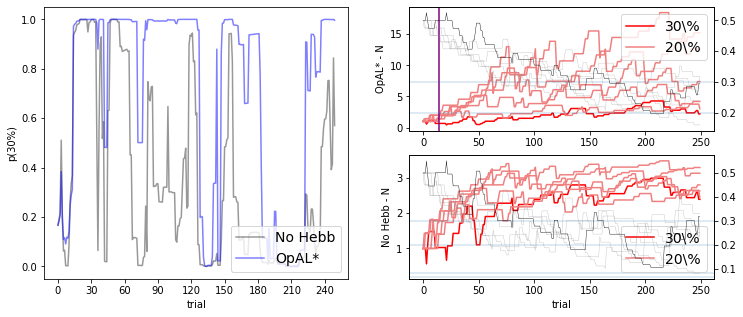

In [27]:
from matplotlib.ticker import MaxNLocator
plt.close('all') 

shift = 0
step = 250
index = 0
fromMe = 0 + shift
tilMe = step + shift
# for i in np.arange(10):
#     print(L_nohebb_signs[i])
xaxis = np.arange(0,step)
sim_to_use = 0 # 

for i in np.arange(1):
    sim_to_use = 8

    fig = plt.figure(figsize = (6*2,5))
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    # plot behavior
    ax1.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.2,.2,.2,0.5))    # L_Q, L_UCB, L_states_OpAL_NoHebb
    ax1.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.0,.0,1.0,0.5))
    # axs[0].legend(["OpAL*","Alt"])
    ax1.set_ylabel("p(30%)")
    ax1.set_xlabel("trial")
    ax1.legend(["No Hebb","OpAL*"],fontsize=14,loc = "lower right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # plot G weights
    ax2.set_ylabel("OpAL* - N")
    ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,0],color="red")
    for alt in np.arange(complexity-1):
        ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,alt+1],color="lightcoral")
    # ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QG[fromMe:tilMe,0],color="green")
    # ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QG[fromMe:tilMe,1],color="lightgreen")
    DAonset = np.where(L_states_OpAL_Star_FORCED[sim_to_use].rho == 0)[0][-1] + 1 # add DA onset
    ax2.axvline(x= DAonset, color = "purple")
    ax2.legend(["30\%","20\%"],fontsize=14,loc = "upper right")

    # convergence
    ax2_twin = ax2.twinx()
    ax2_twin.axhline(y=.3, linewidth = .3)
    ax2_twin.axhline(y=.2, linewidth = .3)
    ax2_twin.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].V[fromMe:tilMe,0],color = "black", linewidth=.4)
    for alt in np.arange(complexity-1):
        ax2_twin.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].V[fromMe:tilMe,alt + 1],color = (0.5,0.5,0.5,0.5),linewidth=.4)

    # plot Q values
    ax3.set_ylabel("No Hebb - N")
    ax3.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].QN[fromMe:tilMe,0],color="red")
    for alt in np.arange(complexity-1):
        ax3.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].QN[fromMe:tilMe,alt+1],color="lightcoral")
    ax3.axhline(y=.3, linewidth = .3)
    ax3.axhline(y=.2, linewidth = .3)
    ax3.legend(["30\%","20\%"], fontsize=14, loc = "lower right")
    ax3.set_xlabel("trial")

    # convergence
    ax3_twin = ax3.twinx()
    ax3_twin.axhline(y=.3, linewidth = .3)
    ax3_twin.axhline(y=.2, linewidth = .3)
    ax3_twin.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].V[fromMe:tilMe,0],color = "black", linewidth=.4)
    for alt in np.arange(complexity-1):
        ax3_twin.plot(xaxis,L_states_OpAL_NoHebb_FORCED[sim_to_use].V[fromMe:tilMe,alt + 1],color = (0.5,0.5,0.5,0.5),linewidth=.4)



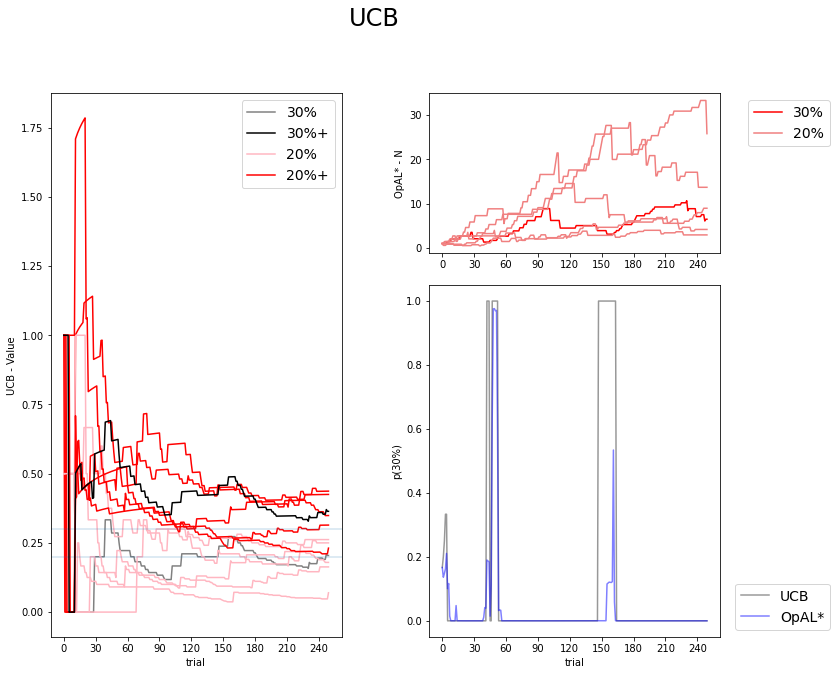

In [28]:
from matplotlib.ticker import MaxNLocator
plt.close('all') 

shift = 0
step = 250
index = 0
fromMe = 0 + shift
tilMe = step + shift
# for i in np.arange(10):
#     print(L_nohebb_signs[i])
xaxis = np.arange(shift,shift+step)

gamma = auc_orders[str_complexity]['UCB'][0]

for i in np.arange(1):
    sim_to_use = i

    fig = plt.figure(figsize = (6*2,10))
    gs = fig.add_gridspec(3,2)
    ax1 = fig.add_subplot(gs[1:3, 1])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[:, 0])

    # plot behavior
    ax1.plot(xaxis,L_UCB_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.2,.2,.2,0.5))  
    ax1.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].SM[fromMe:tilMe,0],color=(.0,.0,1.0,0.5))
    ax1.set_ylabel("p(30%)")
    ax1.set_xlabel("trial")
    ax1.legend(["UCB","OpAL*"],fontsize=14,loc = "lower right",bbox_to_anchor=(1.4, 0.))
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # plot G weights
    ax2.set_ylabel("OpAL* - N")
    ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,0],color="red")
    for alt in np.arange(complexity-1):
        ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QN[fromMe:tilMe,alt+1],color="lightcoral")
    # ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QG[fromMe:tilMe,0],color="green")
    # ax2.plot(xaxis,L_states_OpAL_Star_FORCED[sim_to_use].QG[fromMe:tilMe,1],color="lightgreen")
    DAonset = np.where(L_states_OpAL_Star_FORCED[sim_to_use].rho == 0)[0][-1] + 1 # add DA onset
    # ax2.axvline(x= DAonset, color = "purple")
    ax2.legend(["30%","20%"],fontsize=14,loc = "upper right",bbox_to_anchor=(1.4, 1.))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    # plot Q values
    ax3.set_ylabel("UCB - Value")
    ax3.plot(xaxis,L_UCB_FORCED[sim_to_use].Q[fromMe:tilMe,0] ,color="grey")
    ax3.plot(xaxis,L_UCB_FORCED[sim_to_use].Acts[fromMe:tilMe,0],color="black",zorder=100)
    for alt in np.arange(complexity-1):
        ax3.plot(xaxis,L_UCB_FORCED[sim_to_use].Q[fromMe:tilMe,alt+1],color="lightpink")
        ax3.plot(xaxis,L_UCB_FORCED[sim_to_use].Acts[fromMe:tilMe,alt+1],color="red")
    ax3.axhline(y=.3, linewidth = .3)
    ax3.axhline(y=.2, linewidth = .3)
    ax3.legend(["30%","30%+","20%","20%+"], fontsize=14, loc = "upper right")
    ax3.set_xlabel("trial")
    ax3.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.suptitle('UCB', y=1.0, fontsize=24)
    plt.subplots_adjust(wspace=0.3)